# MSDM5003 (Fall 21/22) Final Project Group 28
# Members: Cheng Wing Kit and Chan Shiu Kai
# Topic: Adaptive Minority Game

In [1]:
import numpy as np
from numpy.random import randint
from random import seed, choice, sample
import matplotlib.pyplot as plt
import time

def theta(xt, xM):
    """Heaviside unit step function"""
    return 1 if xt>xM else 0

def cross_over(p1, p2):
    """
    Crossover function
    Input: 
        p1: 1st parent strategy 
        p2: 2nd parent strategy
    Output: 
        c1: 1st offspring strategy after crossover
        c2: 2nd offspring strategy after crossover
    """
    pos = randint(1, len(p1))
    c1 = np.concatenate((p1[:pos],p2[pos:]))
    c2 = np.concatenate((p2[:pos],p1[pos:]))
    return c1, c2

def replacement_co(d, v, parent='Random', replace='Same'):
    """
    Update strategies with Crossover Scheme
    Input:
        d: strategy array of an agent
        v: virtual score array of an agent's strategies
        parent: Scheme of choosing parent strategies for crossover {'Random','Best'}
        replace: Scheme of choosing strategies to be replaced {'Same','Random','Worst'}
    Output:
        d1: updated strategy array of an agent
        v: updated virtual score array of an agent's strategies
    """ 
    d1 = d.copy()
    ns = len(v)
    if parent == 'Random':
        parents_id = sample(range(ns),2)
    elif parent == 'Best':
        h1 = v.max()
        h2 = np.sort(v)[::-1][1]
        if sum(v>=h2) == 2:
            parents_id = [i for i in range(len(v)) if v[i]>=h2]
        elif h1>h2:
            parents_id = [v.argmax()]
            parents_id.append(choice([i for i in range(len(v)) if (v[i]!=max(v)) & (v[i]==h2)]))
        else:
            parents_id = sample([i for i in range(len(v)) if v[i]==h2], 2)
    child1, child2 = cross_over(d1[parents_id[0],:], d1[parents_id[1],:])
    if replace == 'Same':
        replace_id = parents_id
    elif replace == 'Worst':
        l1 = v.min()
        l2 = np.sort(v)[1]
        if sum(v<=l2) == 2:
            replace_id = [i for i in range(len(v)) if v[i]<=l2]
        elif l1<l2:
            replace_id = [v.argmin()]
            replace_id.append(choice([i for i in range(len(v)) if (v[i]!=min(v)) & (v[i]==l2)]))
        else:
            replace_id = sample([i for i in range(len(v)) if v[i]==l2], 2)
    elif replace == 'Random':
        replace_id = sample(range(ns),2)
    d1[replace_id[0],:] = child1
    d1[replace_id[1],:] = child2
    v[replace_id[0]] = v[parents_id[0]]
    v[replace_id[1]] = v[parents_id[1]]
    return d1, v

def mutation(parent, mode='Tail'):
    """
    Mutation function
    Input: 
        parent: the parent strategy to be mutated
        mode: mode of mutation {'Tail','Long'}
    Output: 
        child: offspring strategy after mutation
    """
    pos = choice(range(len(parent)))
    if (mode == 'Tail') or (pos <= (len(parent)+1)/2):
        flipped = abs(parent[pos:]-1)
        child = np.concatenate((parent[:pos],flipped))
    else:
        flipped = abs(parent[:pos]-1)
        child = np.concatenate((flipped, parent[pos:]))
    return child

def replacement_m(d, v, n=2, mode='Tail'):
    """
    Update strategies with Mutation Scheme
    Input:
        d: strategy array of an agent
        v: virtual score array of an agent's strategies
        n: the number of worst strategies undergo mutation
        mode: mode of mutation {'Tail','Long'}
    Output:
        d1: updated strategy array of an agent
        v: updated virtual score array of an agent's strategies
    """ 
    d1 = d.copy()
    l = np.sort(v)[n-1]
    if sum(v<=l) == n:
        mutate_id = [i for i in range(len(v)) if v[i]<=l]
    else:
        mutate_id = [i for i in range(len(v)) if v[i]<l]
        k = len(mutate_id)
        smid = sample([i for i in range(len(v)) if v[i]==l], n-k)
        for m in smid:
            mutate_id.append(m)
    for mid in mutate_id:
        d1[mid,:] = mutation(d1[mid,:], mode)
        v[mid] = v.max()
    return d1, v

def crossover_mutation(b, w, mode='Long'):
    """
    Crossover mutation function
    Input: 
        b: the best strategy of an agent
        w: target strategy to be mutated
        mode: mode of mutation {'Tail','Long'}
    Output: 
        child: offspring strategy after crossover mutation
    """
    pos = choice(range(len(b)))
    if mode=='Long':
        if pos > (len(b)+1)/2:
            flipped = abs(w[pos:]-1)
            child = np.concatenate((b[:pos],flipped))
        else:
            flipped = abs(w[:pos]-1)
            child = np.concatenate((flipped,b[pos:]))
    else:
        if pos > (len(b)+1)/2:
            flipped = abs(w[:pos]-1)
            child = np.concatenate((flipped,b[pos:]))
        else:
            flipped = abs(w[pos:]-1)
            child = np.concatenate((b[:pos],flipped))            
    return child

def replacement_cm(d, v, n=2, mode='Long'):
    """
    Update strategies with Crossover Mutation Scheme
    Input:
        d: strategy array of an agent
        v: virtual score array of an agent's strategies
        n: the number of worst strategies undergo crossover mutation
        mode: mode of mutation {'Long','Short'}
    Output:
        d1: updated strategy array of an agent
        v: updated virtual score array of an agent's strategies
    """
    d1 = d.copy()
    l = np.sort(v)[n-1]
    bestid = v.argmax()
    if sum(v<=l) == n:
        mutate_id = [i for i in range(len(v)) if v[i]<=l]
    else:
        mutate_id = [i for i in range(len(v)) if v[i]<l]
        k = len(mutate_id)
        smid = sample([i for i in range(len(v)) if v[i]==l], n-k)
        for m in smid:
            mutate_id.append(m)
    for mid in mutate_id:
        d1[mid,:] = crossover_mutation(d1[bestid,:], d1[mid,:], mode=mode)
        v[mid] = v.max()
    return d1, v

def update_scores(d, v, r, jchoice, actions, active, xtt, win):
    """
    Update scores in each iteration
    Input:
        d: strategy array of all agents
        v: virtual score array of all agents
        r: real score array of all agents
        jchoice: array of index of strategy chosen for all agents
        actions: array of groups chosen by each agent
        active: active state of the game
        xtt: array of number of agents choosing action 1
        win: winning group
    Outpt:
        v: updated virtual score array
        r1: updated real score array
        Ux: scaled utility 
    """
    r1 = r.copy()
    xM = (len(jchoice)-1)/2
    Ux = ((1-theta(xtt,xM))*xtt+theta(xtt,xM)*(N-xtt))/xM
    for i in range(N):
        for j in range(ns):
            if d[i,j,active] == win:
                v[i,j] += 1
        if d[i,jchoice[i],active] ==  win:
            r1[i] = r[i] + 1
    return v, r1, Ux

def update_state(current, new, states):
    """
    Update state of the game
    Input:
        current: original state
        new: winning group of the lastest iteration
    Output:
        updated state
    """
    return (2 * current + new) % states

# Simulation of collective behavior

In [2]:
def adaptive_minority(m=3, N=101, ns=2, iterations=1000, n=0.6, tau=10, p='Random', r='Same', form='co', mode='Long'):
    """
    Single simulation of Adptive Minority Game
    Input:
        m: memory of all agents
        N: number of agents
        ns: number of strategies holding for each agent
        iteratons: number of iterations of the game
        n: fraction of worst performing agents to apply adaptive scheme
        tau: time interval for agents checking own performance
        p: Scheme of choosing parent strategies for crossover scheme {'Random','Best'}
        r: Scheme of choosing strategies to be replaced for crossover scheme {'Same','Random','Worst'}
        form: form of adaptive scheme used {'co':Crossover,'m':Mutation,'cm':Crossover Mutation}
        mode: mode of mutation or crossover-mutation {'Tail',Long','Short'}
    Output:
        xt: array of number of agents choosing 1 for all iterations
        rarray: array of real score of all agents for all iterations
        Uxt: array of scaled utility of the system for all iterations
        states_array: array of input states for all iterations
    """
    # Initialization
    states = 2**m # number of states
    sequence = randint(0, 2, N*ns*states)
    darray = sequence.reshape((N, ns, states)) # array of strategies
    varray = np.zeros((N, ns)) # array of virtual scores
    rarray = np.zeros((N, iterations+1)) # array of real scores
    active = 0 # initialize input state at t=0
    states_array = [0]
    xt = [] # array of number of agents choosing action 1
    xM = int((N-1)/2) # max number of winning agents  per interation
    Uxt = []
    # Simulation
    for k in range(1, iterations+1):        
        if k % tau == 0:
            adapt = True
            rsorted = np.sort(rarray[:,k-1])[::-1]
            bound = rsorted[int(N*(1-n))-1]
        else:
            adapt = False
        actions = [] # array of agents' action in each iteration
        jchoice = [] # array of strategy chosen in each iteration
        for i in range(N):
            if adapt:
                if rarray[i,k-1]<=bound:
                    if form == 'co':
                        darray[i,:,:], varray[i,:] = replacement_co(darray[i,:,:], varray[i,:], parent=p, replace=r)
                    elif form == 'm':
                        darray[i,:,:], varray[i,:] = replacement_m(darray[i,:,:], varray[i,:], n=2, mode=mode)
                    elif form == 'cm':
                        darray[i,:,:], varray[i,:] = replacement_cm(darray[i,:,:], varray[i,:], n=2, mode=mode)
            max_v = varray[i,0]
            max_vi = [0]
            for j in range(1,ns):
                if varray[i,j] > max_v:
                    max_v = varray[i,j]
                    max_vi = [j]
                elif varray[i,j] == max_v:
                    max_vi.append(j)
            if len(max_vi)==1:
                jchoice.append(max_vi[0])
            else:
                jchoice.append(choice(max_vi))
            actions.append(darray[i,jchoice[-1],active])
        xt.append(sum(np.array(actions)==1))
        if xt[-1] > xM:
            winning = 0
        else:
            winning = 1
        varray, rarray[:,k], Ux = update_scores(darray, varray, rarray[:,k-1], jchoice, actions, active, xt[-1], winning)
        active = update_state(active, winning, states)
        states_array.append(active)
        Uxt.append(Ux)
    return xt, rarray, Uxt, states_array

In [3]:
def amg_collective_sim(m=3, N=101, ns=2, iterations=1000, n=0.6, tau=10, samples=1, plot_ind=False, plot_U=False):
    parent = ['Random', 'Best']
    replace = ['Same', 'Random', 'Worst']
    mode_m = ['Tail','Long']
    mode_cm = ['Long','Short']
    window = 50
    U = [[],[],[],[],[],[],[],[],[],[],[]]
    c = 0
    # Crossover
    for p in parent:
        for r in replace:
            for s in range(samples):
                st = time.time()
                xt, rarray, Uxt, states_array = adaptive_minority(m, N, ns, iterations, n, tau, p, r, form='co')
                print(f'Simulation Time: {(time.time()-st)/60:2f} mins')
                if plot_ind:
                    plt.figure(figsize=(10,10))
                    plt.plot(xt)
                    plt.ylim(0,N)
                    plt.xlim(0,iterations)
                    plt.xlabel('Time')
                    plt.ylabel('x_t')
                    plt.title(f'Number of agents choosing action 1 with genetic crossover: Parents:{p}, Offsprings:{r}')
                    plt.show()
                u=[np.mean(Uxt[i*window:(i+1)*window]) for i in range(int(iterations/window))]
                U[c].append(u)
            c += 1
    # Mutation 
    for mo in mode_m:
        for s in range(samples):
                st = time.time()
                xt, rarray, Uxt, states_array = adaptive_minority(m, N, ns, iterations, n, tau, form='m', mode=mo)
                print(f'Simulation Time: {(time.time()-st)/60:2f} mins')
                if plot_ind:
                    plt.figure(figsize=(10,10))
                    plt.plot(xt)
                    plt.ylim(0,N)
                    plt.xlim(0,iterations)
                    plt.xlabel('Time')
                    plt.ylabel('x_t')
                    plt.title(f'Number of agents choosing action 1 with genetic mutation: Mode:{mo}')
                    plt.show()
                u=[np.mean(Uxt[i*window:(i+1)*window]) for i in range(int(iterations/window))]
                U[c].append(u)
        c += 1
    # Crossover-mutation
    for mo in mode_cm:
        for s in range(samples):
                st = time.time()
                xt, rarray, Uxt, states_array = adaptive_minority(m, N, ns, iterations, n, tau, form='cm', mode=mo)
                print(f'Simulation Time: {(time.time()-st)/60:2f} mins')
                if plot_ind:
                    plt.figure(figsize=(10,10))
                    plt.plot(xt)
                    plt.ylim(0,N)
                    plt.xlim(0,iterations)
                    plt.xlabel('Time')
                    plt.ylabel('x_t')
                    plt.title(f'Number of agents choosing action 1 with genetic mutation with crossover: Mode:{mo}')
                    plt.show()
                u=[np.mean(Uxt[i*window:(i+1)*window]) for i in range(int(iterations/window))]
                U[c].append(u)
        c += 1
    # Basic MG
    for s in range(samples):
        st = time.time()
        xt, rarray, Uxt, states_array = adaptive_minority(m, N, ns, iterations, n=0)
        print(f'Simulation Time: {(time.time()-st)/60:2f} mins')
        if plot_ind:
            plt.figure(figsize=(10,10))
            plt.plot(xt)
            plt.ylim(0,N)
            plt.xlim(0,iterations)
            plt.xlabel('Time')
            plt.ylabel('x_t')
            plt.title(f'Number of agents choosing action 1 without adaptive scheme')
            plt.show()
        u=[np.mean(Uxt[i*window:(i+1)*window]) for i in range(int(iterations/window))]
        U[c].append(u)    
    # U vs Time
    if plot_U:
        plt.figure(figsize=(10,10))
        marks = ['s','o','D','v','^','p','+','*','x','h','<']
        label = ['A: Crossover - Parents: Random, Offsprings: Same',
                  'B: Crossover - Parents: Random, Offsprings: Random',
                  'C: Crossover - Parents: Random, Offsprings: Worst',
                  'D: Crossover - Parents: Best, Offsprings: Same',
                  'E: Crossover - Parents: Best, Offsprings: Random',
                  'F: Crossover - Parents: Best, Offsprings: Worst',
                  'G: Mutation - Mode: Tail',
                  'H: Mutation - Mode: Long',
                  'I: Mutation with Crossover - Mode: Long',
                  'J: Mutation with Crossover - Mode: Short',
                  'K: No adaptive scheme',]
        for i, u in enumerate(U):
            plt.plot(np.array(u).mean(axis=0), marker=marks[i], linestyle='None', markerfacecolor='None', markersize=5, label=label[i])
        plt.title('Scaled Utility of different adaptive mechanism', fontsize=20)
        plt.xlabel('Scaled Time', fontsize=20)
        plt.ylabel('U', fontsize=20)
        plt.legend(loc=4)
        plt.show()
        # log(1-U) vs log(Time)
        plt.figure(figsize=(10,10))
        for i, u in enumerate(U):
            plt.loglog(1-np.array(u).mean(axis=0), marker=marks[i], linestyle='None', markerfacecolor='None', markersize=5, label=label[i])
        plt.title('Scaled Utility deviation from U_max = 1 of different adaptive mechanism', fontsize=20)
        plt.xlabel('Scaled Time', fontsize=20)
        plt.ylabel('1-U', fontsize=20)
        plt.ylim(0.00001,1)
        plt.legend(loc=3)
        plt.show()
    return U

Simulation Time: 1.176796 mins


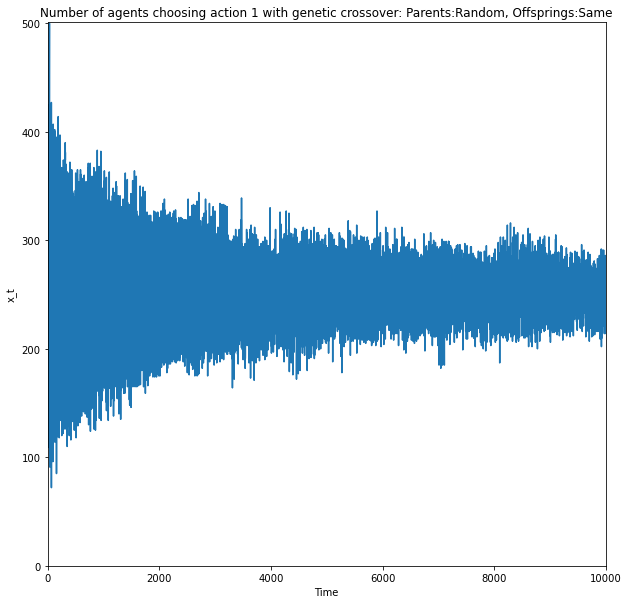

Simulation Time: 1.222098 mins


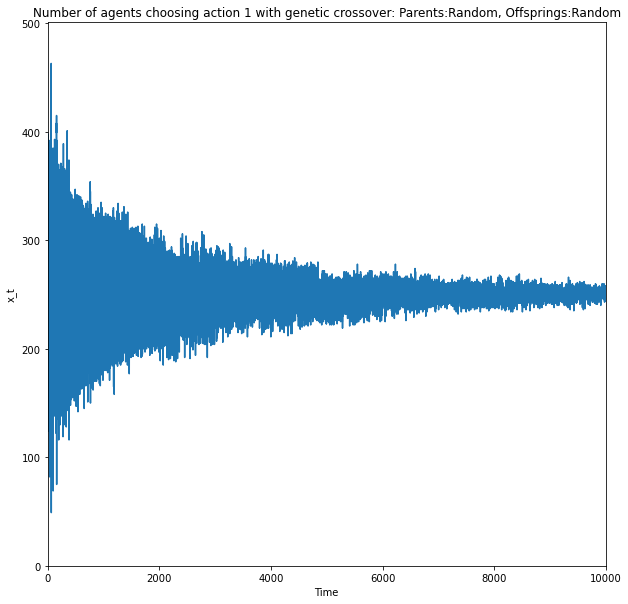

Simulation Time: 1.246317 mins


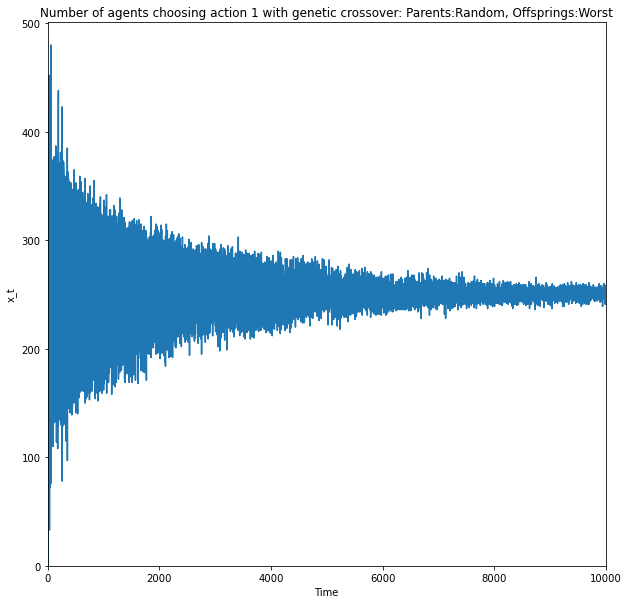

Simulation Time: 1.210658 mins


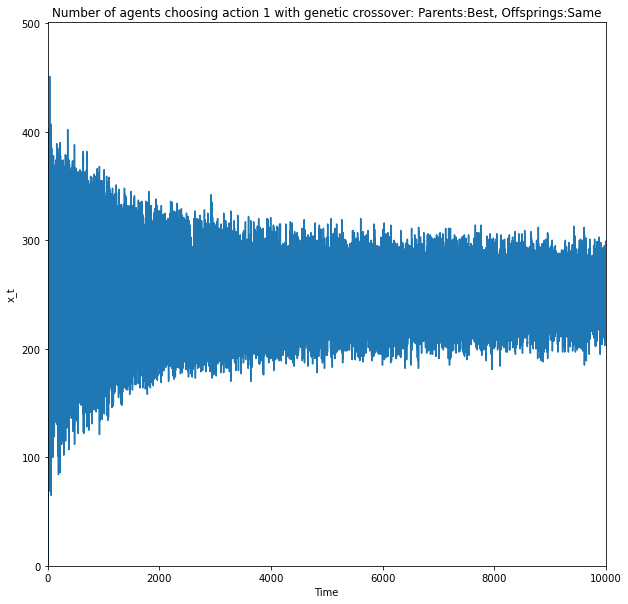

Simulation Time: 1.267014 mins


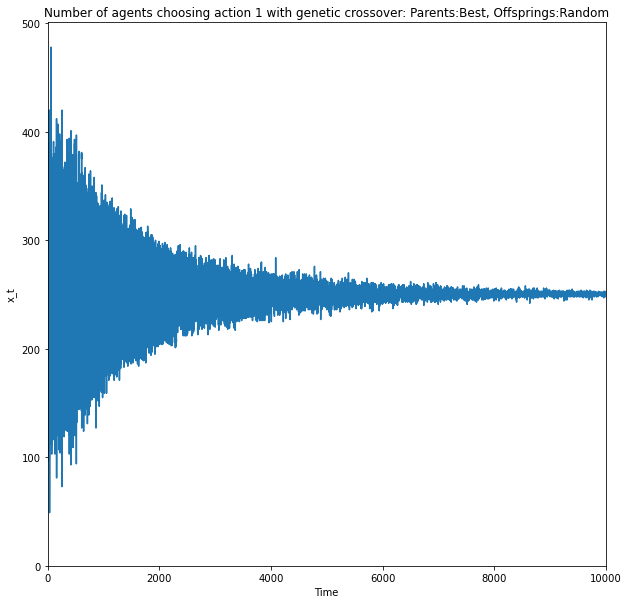

Simulation Time: 1.295700 mins


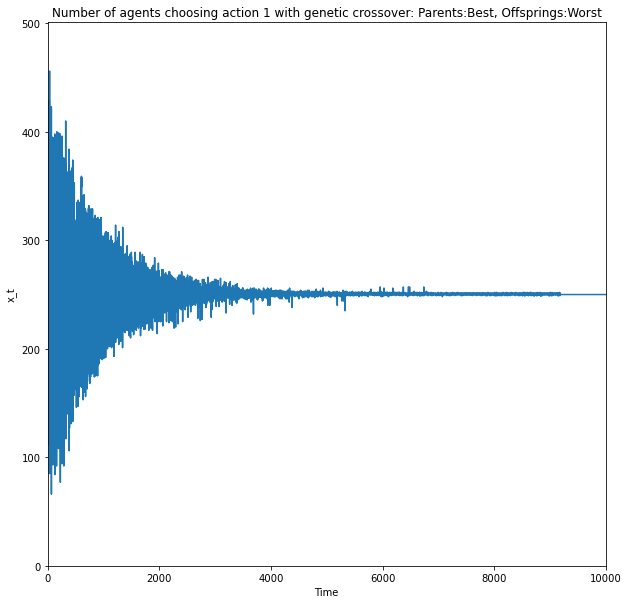

Simulation Time: 1.206123 mins


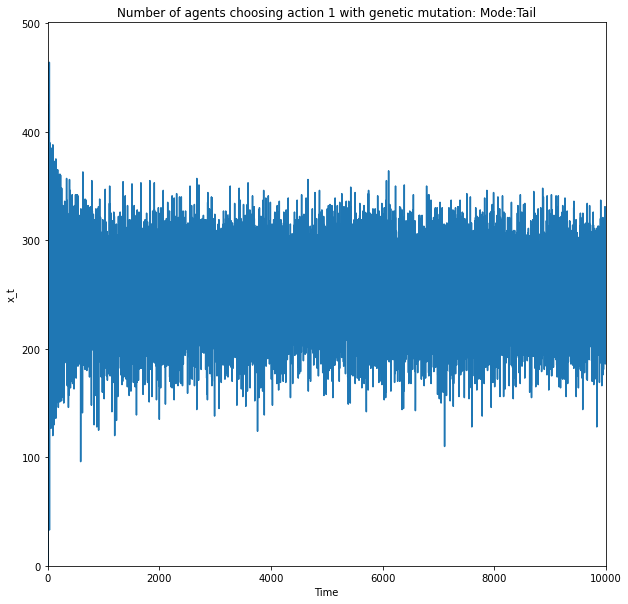

Simulation Time: 1.205702 mins


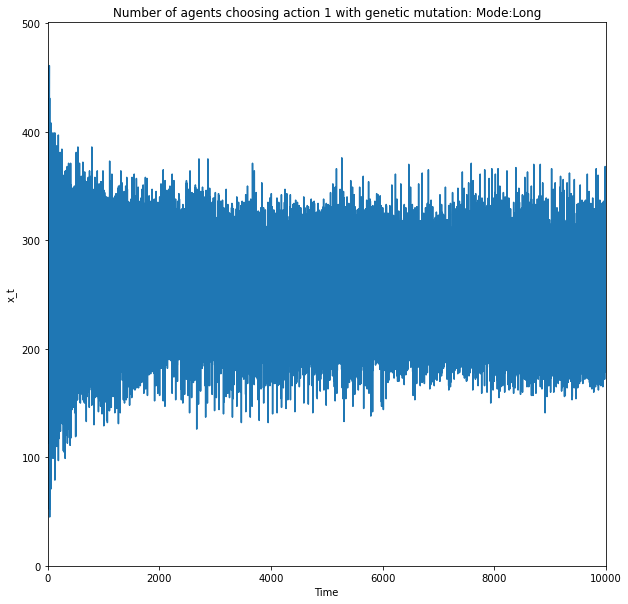

Simulation Time: 1.229704 mins


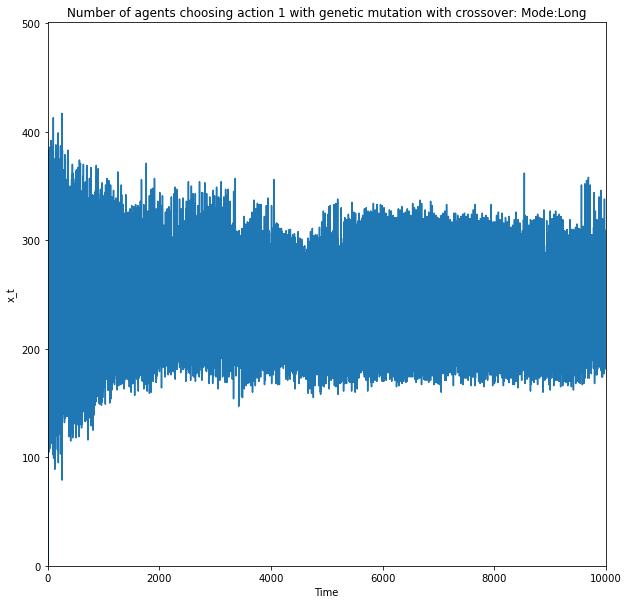

Simulation Time: 1.229423 mins


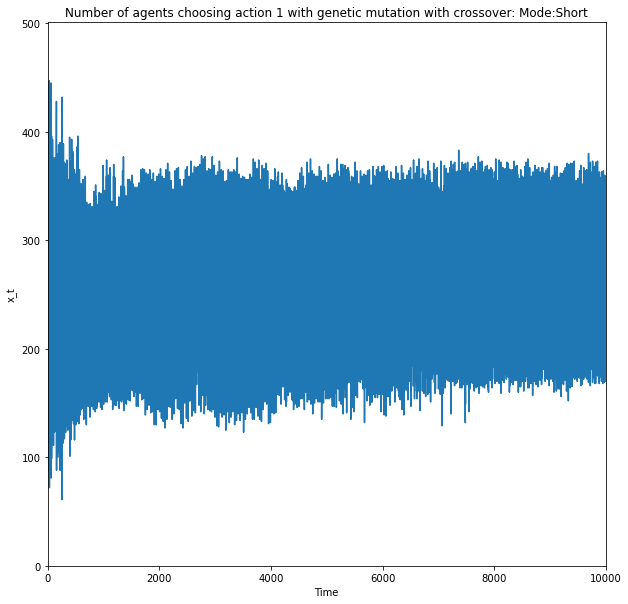

Simulation Time: 1.173650 mins


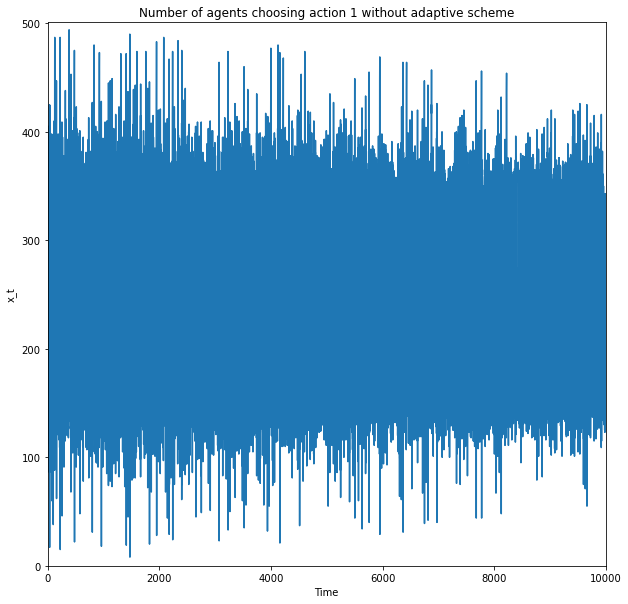

Simulation Time: 1.168866 mins
Simulation Time: 1.166695 mins
Simulation Time: 1.168981 mins
Simulation Time: 1.165378 mins
Simulation Time: 1.172328 mins
Simulation Time: 1.170281 mins
Simulation Time: 1.170138 mins
Simulation Time: 1.175534 mins
Simulation Time: 1.167280 mins
Simulation Time: 1.170755 mins
Simulation Time: 1.172457 mins
Simulation Time: 1.170658 mins
Simulation Time: 1.170915 mins
Simulation Time: 1.169608 mins
Simulation Time: 1.167807 mins
Simulation Time: 1.178401 mins
Simulation Time: 1.168902 mins
Simulation Time: 1.172428 mins
Simulation Time: 1.168271 mins
Simulation Time: 1.170880 mins
Simulation Time: 1.170946 mins
Simulation Time: 1.168499 mins
Simulation Time: 1.168000 mins
Simulation Time: 1.170129 mins
Simulation Time: 1.178980 mins
Simulation Time: 1.176546 mins
Simulation Time: 1.184052 mins
Simulation Time: 1.173429 mins
Simulation Time: 1.170167 mins
Simulation Time: 1.172041 mins
Simulation Time: 1.208106 mins
Simulation Time: 1.206831 mins
Simulati

Simulation Time: 1.228398 mins
Simulation Time: 1.231192 mins
Simulation Time: 1.241500 mins
Simulation Time: 1.232245 mins
Simulation Time: 1.235335 mins
Simulation Time: 1.214673 mins
Simulation Time: 1.215615 mins
Simulation Time: 1.215328 mins
Simulation Time: 1.212403 mins
Simulation Time: 1.211621 mins
Simulation Time: 1.219052 mins
Simulation Time: 1.210942 mins
Simulation Time: 1.210585 mins
Simulation Time: 1.210617 mins
Simulation Time: 1.212829 mins
Simulation Time: 1.212716 mins
Simulation Time: 1.212548 mins
Simulation Time: 1.214235 mins
Simulation Time: 1.209919 mins
Simulation Time: 1.222567 mins
Simulation Time: 1.210832 mins
Simulation Time: 1.210272 mins
Simulation Time: 1.212688 mins
Simulation Time: 1.210617 mins
Simulation Time: 1.212282 mins
Simulation Time: 1.212182 mins
Simulation Time: 1.211504 mins
Simulation Time: 1.223968 mins
Simulation Time: 1.209603 mins
Simulation Time: 1.210596 mins
Simulation Time: 1.209951 mins
Simulation Time: 1.210983 mins
Simulati

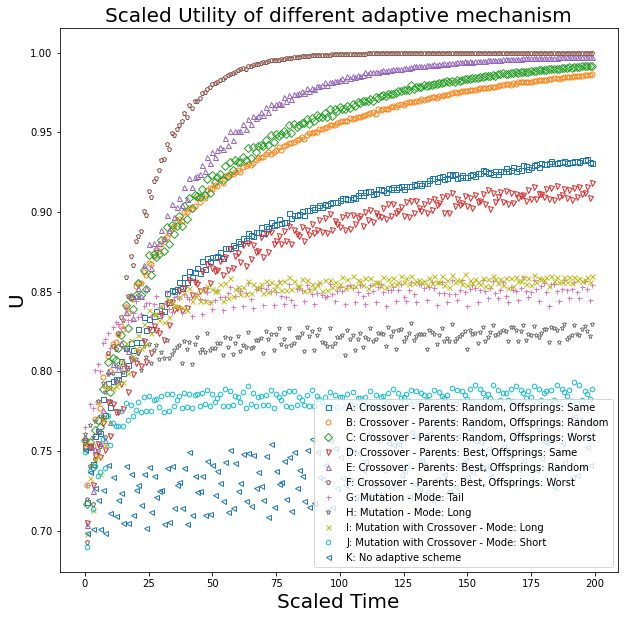

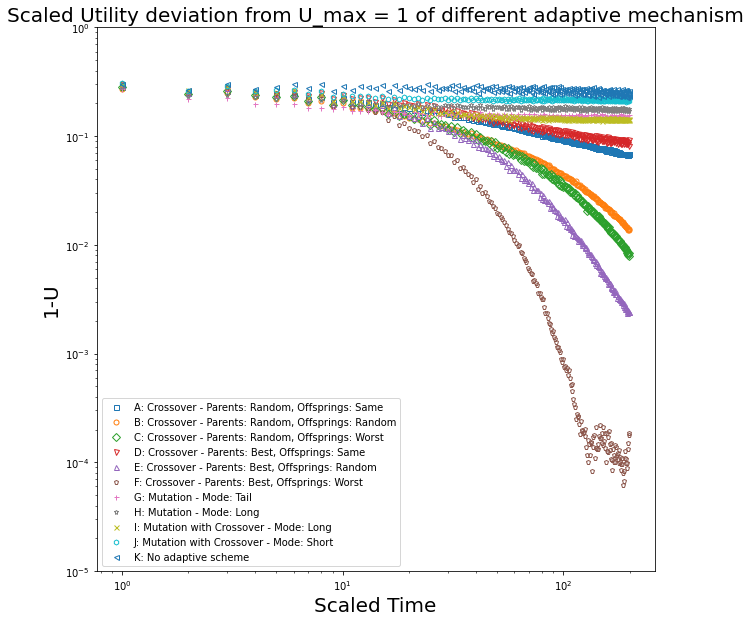

In [4]:
m = 4
N = 501
ns = 10
iterations = 10000
n = 0.3
tau = 40
window = 50
U = amg_collective_sim(m, N, ns, iterations, n, tau, 1, plot_ind=True, plot_U=False)
U = amg_collective_sim(m, N, ns, iterations, n, tau, 30, plot_ind=False, plot_U=True)

# Simulation of revenge ability

In [5]:
def mg_revenge(form='co', p1='Random', p2='Same', scheme='A'):
    """
    Simulation of revenge game
    Input:
        form: form of adaptive scheme used {'co':Crossover,'m':Mutation,'cm':Crossover Mutation}
        p1: parameter 1 of the adaptive scheme - crossover:{'Random','Best'}, mutation:{'Tail','Long'}, crossover-mutation:{'Long','Short'}
        p2: parameter 2 of the crossover scheme: {'Same','Random','Worst'}
        scheme: scheme caption used in title of the plot
    Output:
        xt: array of number of agents choosing 1 for all iterations
        rarray: array of real score of all agents for all iterations
        target_agent: array of index of agents applying the adatpive scheme
        states_array: array of input states for all iterations
    """
    m = 4
    N = 501
    ns = 10
    iterations = 10000
    tt = 3000
    n = 0.3
    tau = 40
    xM = int((N-1)/2)
    states = 2**m # number of states
    sequence = randint(0, 2, N*ns*states)
    darray = sequence.reshape((N, ns, states)) # array of strategies
    varray = np.zeros((N, ns)) # array of virtual scores
    rarray = np.zeros((N, iterations+1)) # array of real scores
    active = 0 # initialize input state at t=0
    states_array = [0]
    xt = [] # array of number of agents choosing action 1
    target_agent = [] # array of the worst 5 agents at t=tt
    adapt = False
    # Simulation
    for k in range(1, iterations+1):
        if k == tt:
            target_agent = rarray[:,tt-1].argsort()[:5]
        if k>= tt:
            if k % tau == 0:
                adapt = True
                rsorted = np.sort(rarray[:,k-1])[::-1]
                bound = rsorted[int(N*(1-n))-1]
            else:
                adapt = False
        actions = [] # array of agents' action in each iteration
        jchoice = [] # array of strategy chosen in each iteration
        for i in range(N):
            if adapt and (i in target_agent):
                if rarray[i,k-1]<=bound:
                    if form == 'co':
                        darray[i,:,:], varray[i,:] = replacement_co(darray[i,:,:], varray[i,:], p1, p2)
                    elif form == 'm':
                        darray[i,:,:], varray[i,:] = replacement_m(darray[i,:,:], varray[i,:], 2, p1)
                    else:
                        darray[i,:,:], varray[i,:] = replacement_cm(darray[i,:,:], varray[i,:], 2, p1)
            max_v = varray[i,0]
            max_vi = [0]
            for j in range(1,ns):
                if varray[i,j] > max_v:
                    max_v = varray[i,j]
                    max_vi = [j]
                elif varray[i,j] == max_v:
                    max_vi.append(j)
            if len(max_vi)==1:
                jchoice.append(max_vi[0])
            else:
                jchoice.append(choice(max_vi))
            actions.append(darray[i,jchoice[-1],active])
        xt.append(sum(np.array(actions)==1))
        if xt[-1] > xM:
            winning = 0
        else:
            winning = 1
        varray, rarray[:,k], _ = update_scores(darray, varray, rarray[:,k-1], jchoice, actions, active, xt[-1], winning)
        active = update_state(active, winning, states)
        states_array.append(active)
    r_norm = rarray-rarray.mean(axis=0)
    normal_agents = [i for i in range(N) if (i not in target_agent)]
    # Plotting
    plt.figure(figsize=(10,10))
    for idx, i in enumerate(normal_agents):
        if idx == 0:
            plt.plot(r_norm[i,:], c='g', label='Other agents playing basic minority game')
        else:
            plt.plot(r_norm[i,:], c='g')
    for idx, i in enumerate(target_agent):
        if idx == 0:
            plt.plot(r_norm[i,:], c='b', label=f'Agents with adaptive scheme {scheme} after t={tt}')
        else:
            plt.plot(r_norm[i,:], c='b')
    plt.title(f'Revenge ability of adatpive scheme {scheme}')
    plt.legend()
    plt.show()
    return xt, rarray, target_agent, states_array

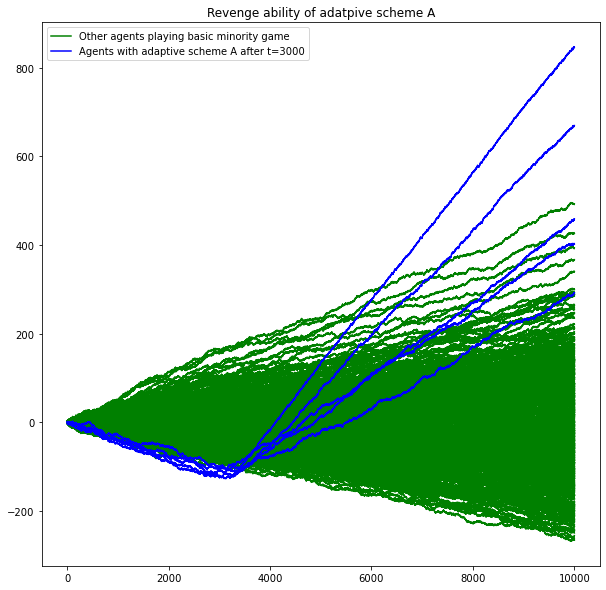

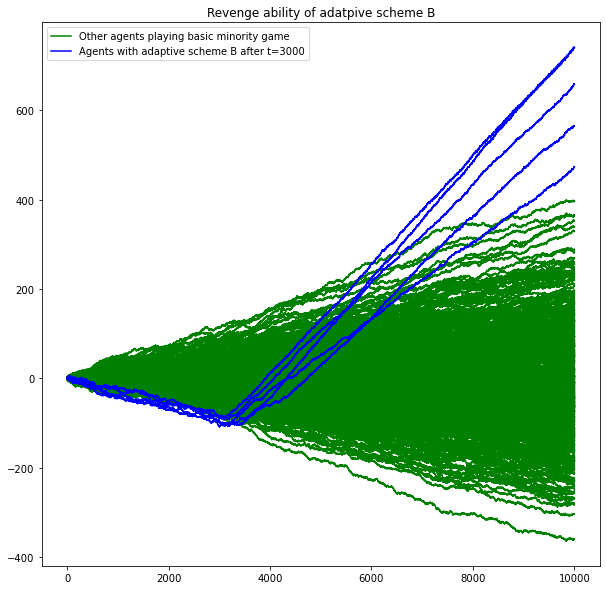

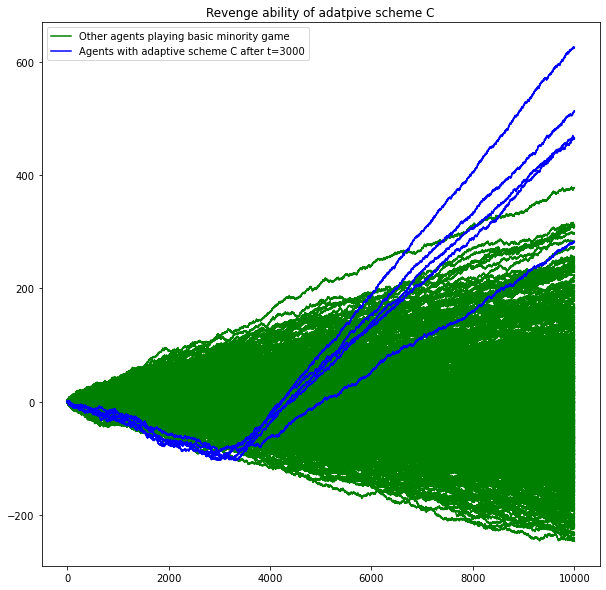

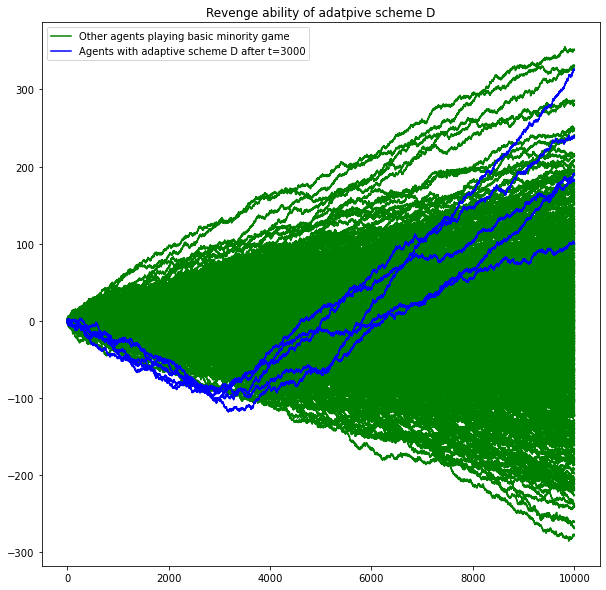

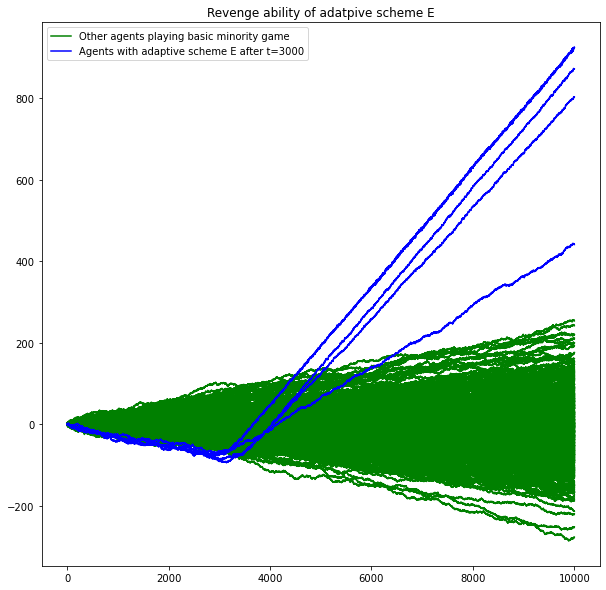

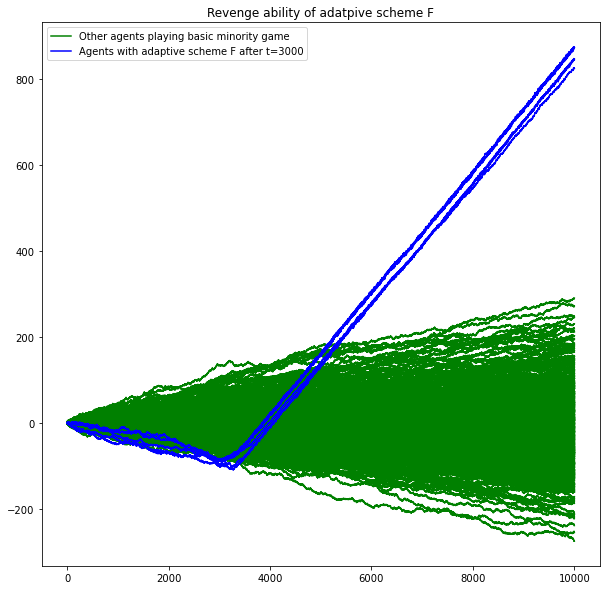

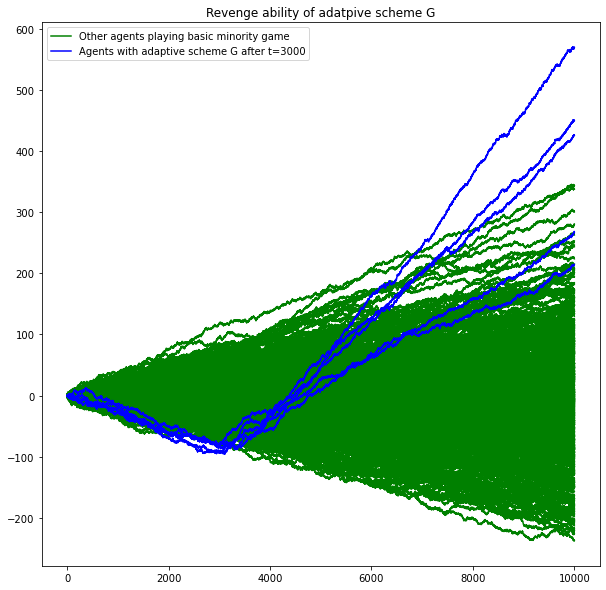

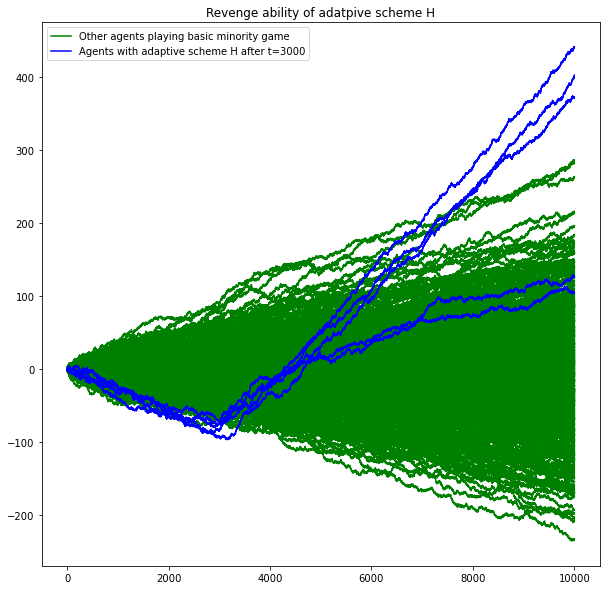

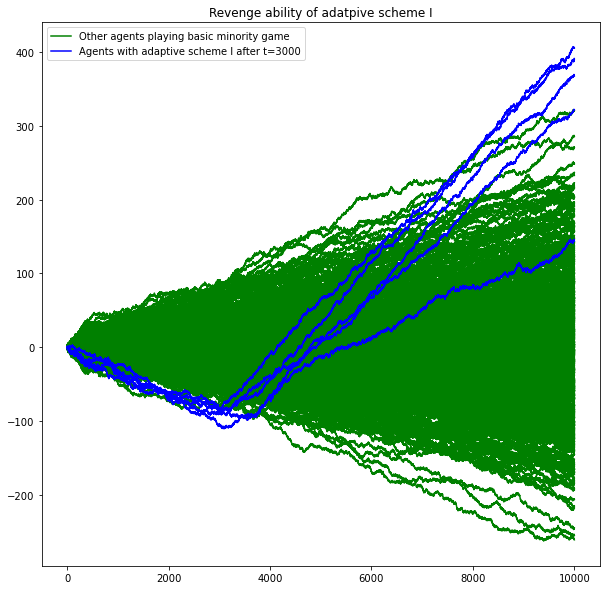

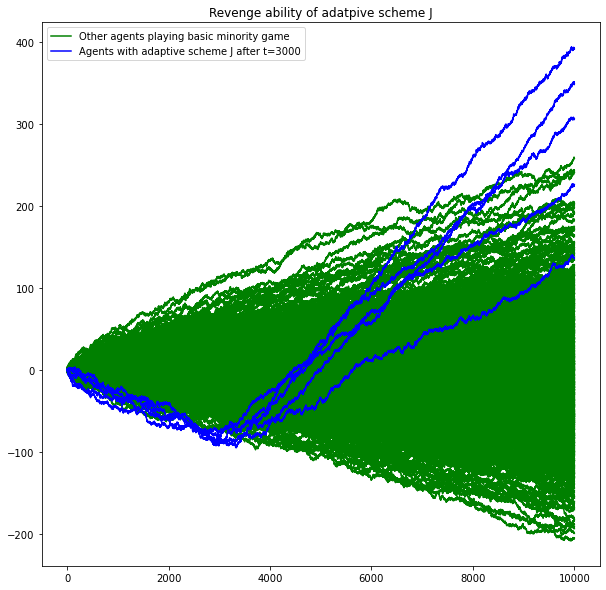

In [6]:
# Generate the revenge plot
parent = ['Random', 'Best']
replace = ['Same', 'Random', 'Worst']
mode_m = ['Tail','Long']
mode_cm = ['Long','Short']
schemes = ['A','B','C','D','E','F','G','H','I','J']
c = 0
for p in parent:
    for r in replace:
        mg_revenge(form='co', p1=p, p2=r, scheme=schemes[c])
        c += 1
for m in mode_m:
    mg_revenge(form='m', p1=m, scheme=schemes[c])
    c += 1
for m in mode_cm:
    mg_revenge(form='cm', p1=m, scheme=schemes[c])
    c += 1

# Simulation on relative performance

In [7]:
def mg_competition(n=0.4,tau=10):
    """
    Simulation of mixed game
    Input:
        n: fraction of the worst agents to apply adaptive scheme
        tau: period that agents check if they need to change strategies
    Output:
        xt: array of number of agents choosing 1 for all iterations
        rarray: array of real score of all agents for all iterations
        groups: array of index of agents in different groups
    """
    def update_scores(d, v, r, jchoice, actions, active, win):
        r1 = r.copy()
        for i in range(N):
            for j in range(ns):
                if d[i,j,active] == win:
                    v[i,j] += 1
            if d[i,jchoice[i],active] ==  win:
                r1[i] = r[i] + 1
        return v, r1
    
    def update_state(current, new):
        return (2 * current + new) % states
    
    # Initialization
    m = 4
    N = 49*11
    ns = 10
    iterations = 10000
    tt = 3000
    xM = int((N-1)/2)
    states = 2**m # number of states
    sequence = randint(0, 2, N*ns*states)
    darray = sequence.reshape((N, ns, states)) # array of strategies
    varray = np.zeros((N, ns)) # array of virtual scores
    rarray = np.zeros((N, iterations+1)) # array of real scores
    active = 0 # initialize input state at t=0
    states_array = [0]
    xt = [] # array of number of agents choosing action 1
    groups = list(np.split(np.random.permutation(N), 11))
    adapt = False
    # Simulation
    print(f'Simulating competition with m={m},N={N},S={ns},T={iterations},tau={tau},n={n}')
    for k in range(1, iterations+1):
        if (k % tau == 0) and (k>=tt):
            adapt = True
            rsorted = np.sort(rarray[:,k-1])[::-1]
            bound = rsorted[int(N*(1-n))-1]
        else:
            adapt = False
            bound = 0
        actions = [] # array of agents' action in each iteration
        jchoice = [] # array of strategy chosen in each iteration
        for i in range(N):
            if adapt and (rarray[i,k-1]<=bound):
                if  i in groups[0]:
                    darray[i,:,:], varray[i,:] = replacement_co(darray[i,:,:], varray[i,:], 'Random', 'Same')
                elif i in groups[1]:
                    darray[i,:,:], varray[i,:] = replacement_co(darray[i,:,:], varray[i,:], 'Random', 'Random')
                elif i in groups[2]:
                    darray[i,:,:], varray[i,:] = replacement_co(darray[i,:,:], varray[i,:], 'Random', 'Worst')
                elif i in groups[3]:
                    darray[i,:,:], varray[i,:] = replacement_co(darray[i,:,:], varray[i,:], 'Best', 'Same')
                elif i in groups[4]:
                    darray[i,:,:], varray[i,:] = replacement_co(darray[i,:,:], varray[i,:], 'Best', 'Random')
                elif i in groups[5]:
                    darray[i,:,:], varray[i,:] = replacement_co(darray[i,:,:], varray[i,:], 'Best', 'Worst')
                elif i in groups[6]:
                    darray[i,:,:], varray[i,:] = replacement_m(darray[i,:,:], varray[i,:], 2, mode='Tail')
                elif i in groups[7]:
                    darray[i,:,:], varray[i,:] = replacement_m(darray[i,:,:], varray[i,:], 2, mode='Long')
                elif i in groups[8]:
                    darray[i,:,:], varray[i,:] = replacement_cm(darray[i,:,:], varray[i,:], 2, mode='Long')
                elif i in groups[9]:
                    darray[i,:,:], varray[i,:] = replacement_cm(darray[i,:,:], varray[i,:], 2, mode='Short')
            max_v = varray[i,0]
            max_vi = [0]
            for j in range(1,ns):
                if varray[i,j] > max_v:
                    max_v = varray[i,j]
                    max_vi = [j]
                elif varray[i,j] == max_v:
                    max_vi.append(j)
            if len(max_vi)==1:
                jchoice.append(max_vi[0])
            else:
                jchoice.append(choice(max_vi))
            actions.append(darray[i,jchoice[-1],active])
        xt.append(sum(np.array(actions)==1))
        if xt[-1] > xM:
            winning = 0
        else:
            winning = 1
        varray, rarray[:,k] = update_scores(darray, varray, rarray[:,k-1], jchoice, actions, active, winning)
        active = update_state(active, winning)
        states_array.append(active)
    return xt, rarray, groups

n=0.1, tau=10, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.1
Simulation Time: 1.302160 mins
n=0.1, tau=10, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.1
Simulation Time: 1.302009 mins
n=0.1, tau=10, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.1
Simulation Time: 1.312693 mins
n=0.1, tau=10, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.1
Simulation Time: 1.298531 mins
n=0.1, tau=10, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.1
Simulation Time: 1.302364 mins
n=0.1, tau=10, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.1
Simulation Time: 1.303391 mins
n=0.1, tau=10, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.1
Simulation Time: 1.301034 mins
n=0.1, tau=10, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.1
Simulation Time: 1.303162 mins
n=0.1, tau=10, Sample 9
Simulating competition w

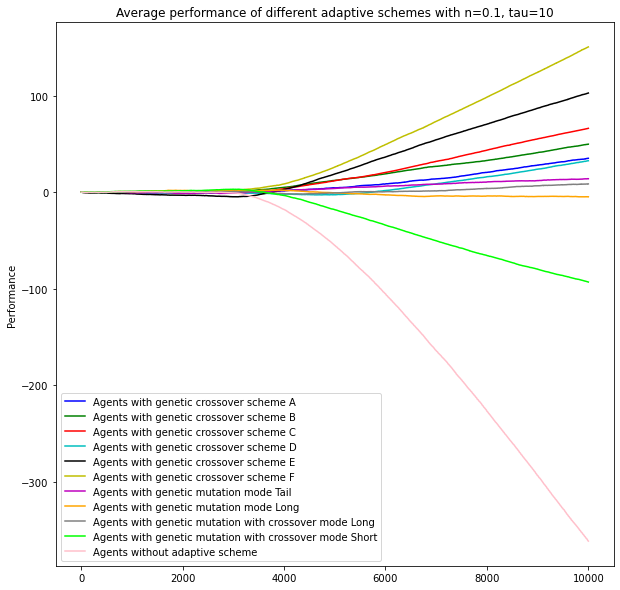

n=0.1, tau=20, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.1
Simulation Time: 1.285675 mins
n=0.1, tau=20, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.1
Simulation Time: 1.285777 mins
n=0.1, tau=20, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.1
Simulation Time: 1.289061 mins
n=0.1, tau=20, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.1
Simulation Time: 1.285005 mins
n=0.1, tau=20, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.1
Simulation Time: 1.285895 mins
n=0.1, tau=20, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.1
Simulation Time: 1.288059 mins
n=0.1, tau=20, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.1
Simulation Time: 1.287625 mins
n=0.1, tau=20, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.1
Simulation Time: 1.297806 mins
n=0.1, tau=20, Sample 9
Simulating competition w

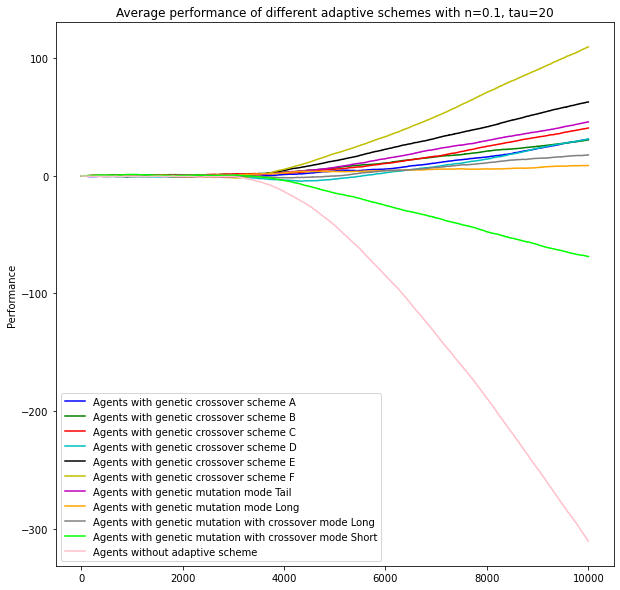

n=0.1, tau=30, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.1
Simulation Time: 1.276802 mins
n=0.1, tau=30, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.1
Simulation Time: 1.279102 mins
n=0.1, tau=30, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.1
Simulation Time: 1.278137 mins
n=0.1, tau=30, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.1
Simulation Time: 1.280780 mins
n=0.1, tau=30, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.1
Simulation Time: 1.277125 mins
n=0.1, tau=30, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.1
Simulation Time: 1.291657 mins
n=0.1, tau=30, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.1
Simulation Time: 1.277681 mins
n=0.1, tau=30, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.1
Simulation Time: 1.287869 mins
n=0.1, tau=30, Sample 9
Simulating competition w

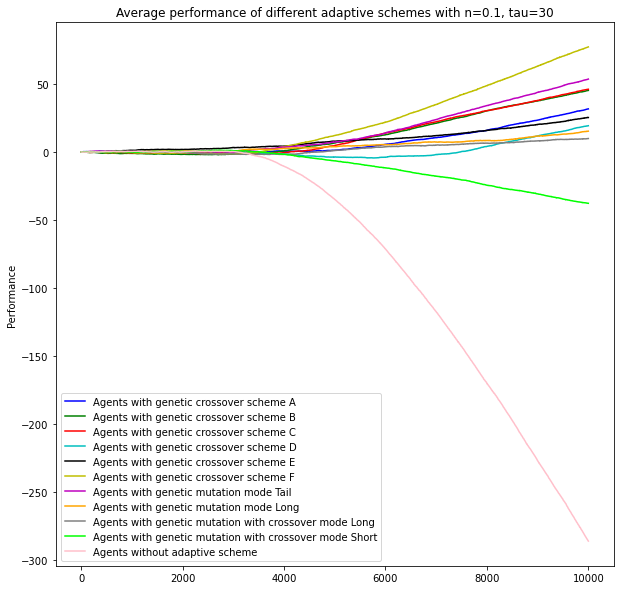

n=0.1, tau=40, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.1
Simulation Time: 1.276970 mins
n=0.1, tau=40, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.1
Simulation Time: 1.276651 mins
n=0.1, tau=40, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.1
Simulation Time: 1.275237 mins
n=0.1, tau=40, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.1
Simulation Time: 1.287485 mins
n=0.1, tau=40, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.1
Simulation Time: 1.274829 mins
n=0.1, tau=40, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.1
Simulation Time: 1.273816 mins
n=0.1, tau=40, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.1
Simulation Time: 1.276779 mins
n=0.1, tau=40, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.1
Simulation Time: 1.278679 mins
n=0.1, tau=40, Sample 9
Simulating competition w

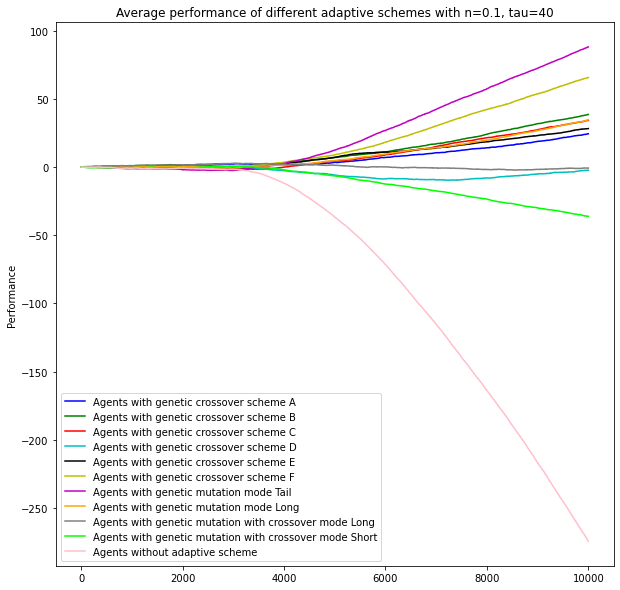

n=0.1, tau=50, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.1
Simulation Time: 1.288938 mins
n=0.1, tau=50, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.1
Simulation Time: 1.273960 mins
n=0.1, tau=50, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.1
Simulation Time: 1.280584 mins
n=0.1, tau=50, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.1
Simulation Time: 1.275181 mins
n=0.1, tau=50, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.1
Simulation Time: 1.277829 mins
n=0.1, tau=50, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.1
Simulation Time: 1.274815 mins
n=0.1, tau=50, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.1
Simulation Time: 1.275660 mins
n=0.1, tau=50, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.1
Simulation Time: 1.274508 mins
n=0.1, tau=50, Sample 9
Simulating competition w

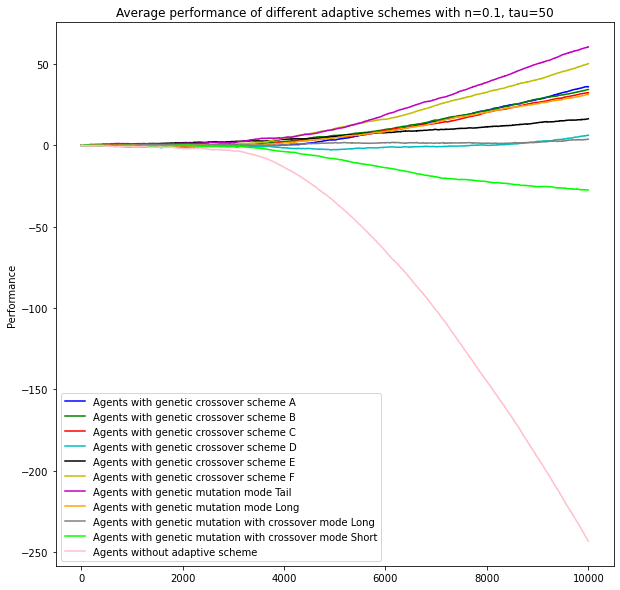

n=0.1, tau=60, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.1
Simulation Time: 1.284167 mins
n=0.1, tau=60, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.1
Simulation Time: 1.275490 mins
n=0.1, tau=60, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.1
Simulation Time: 1.273577 mins
n=0.1, tau=60, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.1
Simulation Time: 1.274028 mins
n=0.1, tau=60, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.1
Simulation Time: 1.273005 mins
n=0.1, tau=60, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.1
Simulation Time: 1.272974 mins
n=0.1, tau=60, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.1
Simulation Time: 1.285689 mins
n=0.1, tau=60, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.1
Simulation Time: 1.271302 mins
n=0.1, tau=60, Sample 9
Simulating competition w

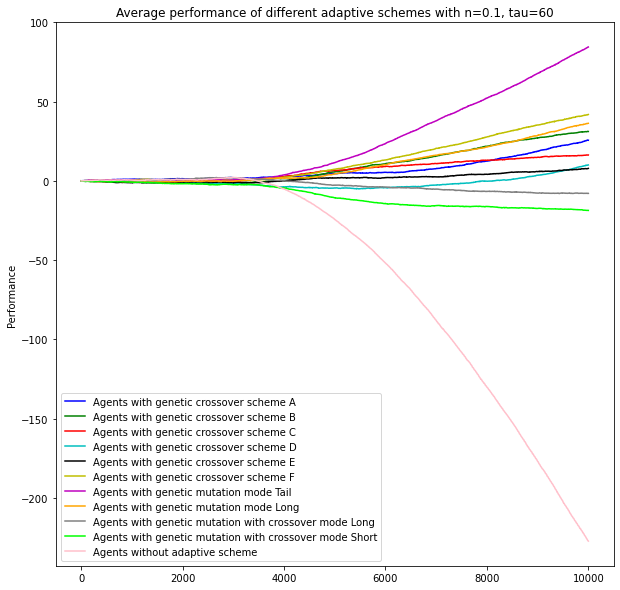

n=0.2, tau=10, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.2
Simulation Time: 1.356093 mins
n=0.2, tau=10, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.2
Simulation Time: 1.358698 mins
n=0.2, tau=10, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.2
Simulation Time: 1.356866 mins
n=0.2, tau=10, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.2
Simulation Time: 1.352382 mins
n=0.2, tau=10, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.2
Simulation Time: 1.372570 mins
n=0.2, tau=10, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.2
Simulation Time: 1.354116 mins
n=0.2, tau=10, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.2
Simulation Time: 1.355572 mins
n=0.2, tau=10, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.2
Simulation Time: 1.356203 mins
n=0.2, tau=10, Sample 9
Simulating competition w

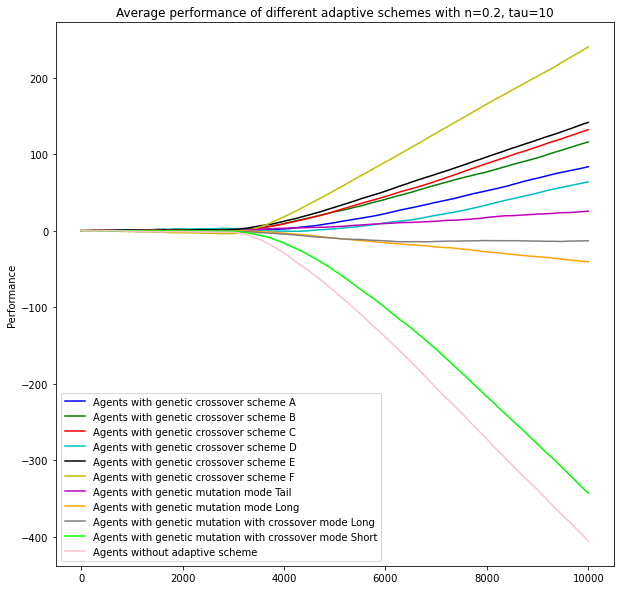

n=0.2, tau=20, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.2
Simulation Time: 1.313777 mins
n=0.2, tau=20, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.2
Simulation Time: 1.325433 mins
n=0.2, tau=20, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.2
Simulation Time: 1.310477 mins
n=0.2, tau=20, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.2
Simulation Time: 1.312456 mins
n=0.2, tau=20, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.2
Simulation Time: 1.314044 mins
n=0.2, tau=20, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.2
Simulation Time: 1.311339 mins
n=0.2, tau=20, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.2
Simulation Time: 1.319384 mins
n=0.2, tau=20, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.2
Simulation Time: 1.310653 mins
n=0.2, tau=20, Sample 9
Simulating competition w

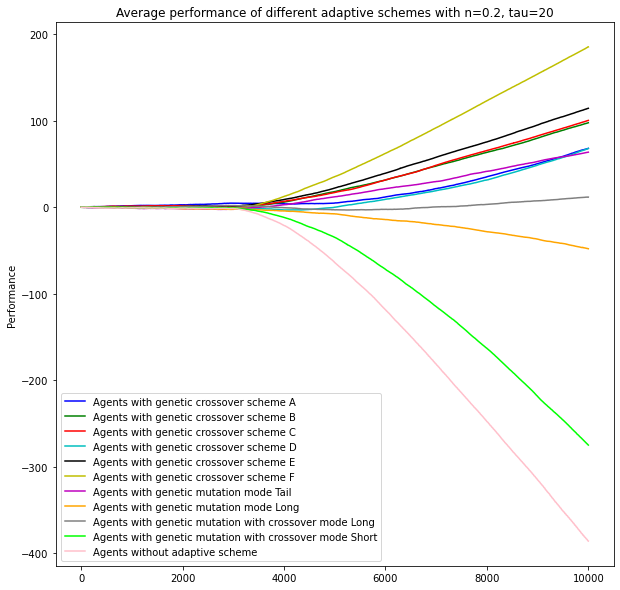

n=0.2, tau=30, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.2
Simulation Time: 1.299003 mins
n=0.2, tau=30, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.2
Simulation Time: 1.297089 mins
n=0.2, tau=30, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.2
Simulation Time: 1.297710 mins
n=0.2, tau=30, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.2
Simulation Time: 1.296829 mins
n=0.2, tau=30, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.2
Simulation Time: 1.297688 mins
n=0.2, tau=30, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.2
Simulation Time: 1.297920 mins
n=0.2, tau=30, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.2
Simulation Time: 1.311920 mins
n=0.2, tau=30, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.2
Simulation Time: 1.297750 mins
n=0.2, tau=30, Sample 9
Simulating competition w

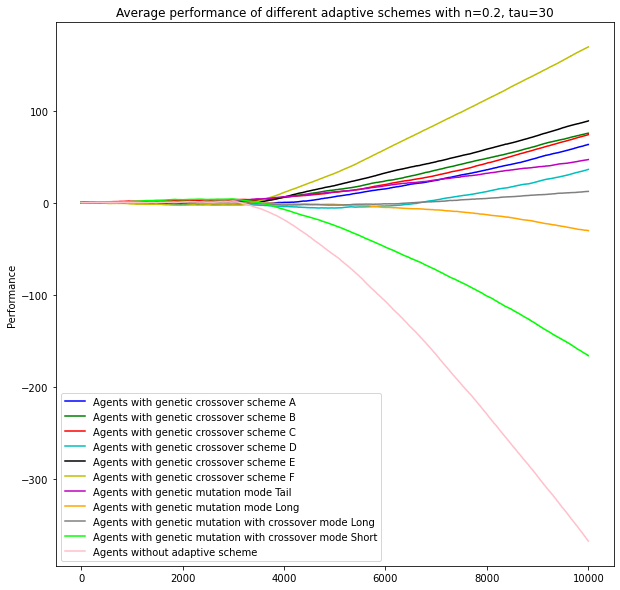

n=0.2, tau=40, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.2
Simulation Time: 1.291157 mins
n=0.2, tau=40, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.2
Simulation Time: 1.293419 mins
n=0.2, tau=40, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.2
Simulation Time: 1.300127 mins
n=0.2, tau=40, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.2
Simulation Time: 1.289772 mins
n=0.2, tau=40, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.2
Simulation Time: 1.304104 mins
n=0.2, tau=40, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.2
Simulation Time: 1.299821 mins
n=0.2, tau=40, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.2
Simulation Time: 1.291218 mins
n=0.2, tau=40, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.2
Simulation Time: 1.290242 mins
n=0.2, tau=40, Sample 9
Simulating competition w

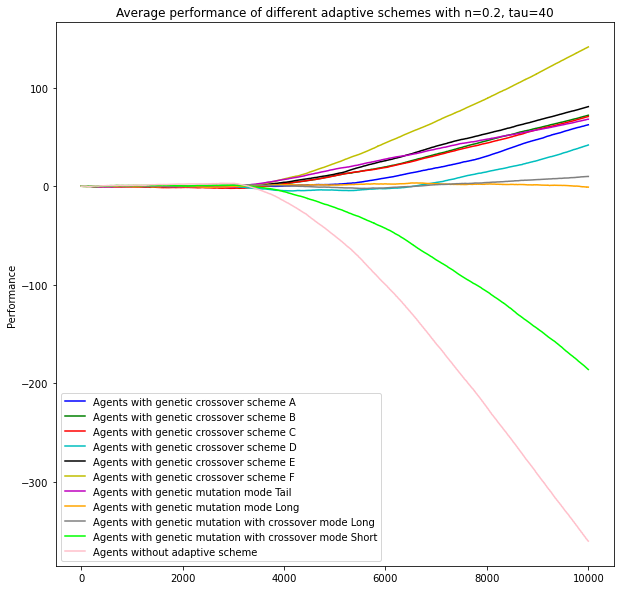

n=0.2, tau=50, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.2
Simulation Time: 1.287261 mins
n=0.2, tau=50, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.2
Simulation Time: 1.284152 mins
n=0.2, tau=50, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.2
Simulation Time: 1.295957 mins
n=0.2, tau=50, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.2
Simulation Time: 1.289976 mins
n=0.2, tau=50, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.2
Simulation Time: 1.288037 mins
n=0.2, tau=50, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.2
Simulation Time: 1.286804 mins
n=0.2, tau=50, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.2
Simulation Time: 1.287492 mins
n=0.2, tau=50, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.2
Simulation Time: 1.285558 mins
n=0.2, tau=50, Sample 9
Simulating competition w

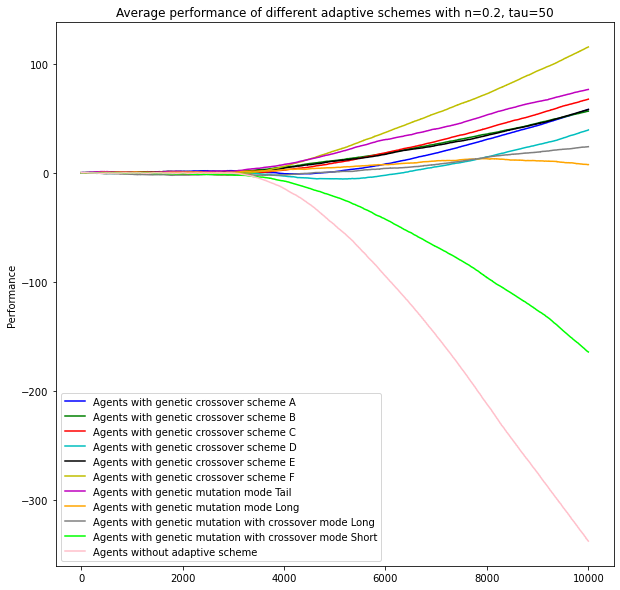

n=0.2, tau=60, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.2
Simulation Time: 1.285313 mins
n=0.2, tau=60, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.2
Simulation Time: 1.281318 mins
n=0.2, tau=60, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.2
Simulation Time: 1.281736 mins
n=0.2, tau=60, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.2
Simulation Time: 1.283406 mins
n=0.2, tau=60, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.2
Simulation Time: 1.282237 mins
n=0.2, tau=60, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.2
Simulation Time: 1.281746 mins
n=0.2, tau=60, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.2
Simulation Time: 1.282609 mins
n=0.2, tau=60, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.2
Simulation Time: 1.293138 mins
n=0.2, tau=60, Sample 9
Simulating competition w

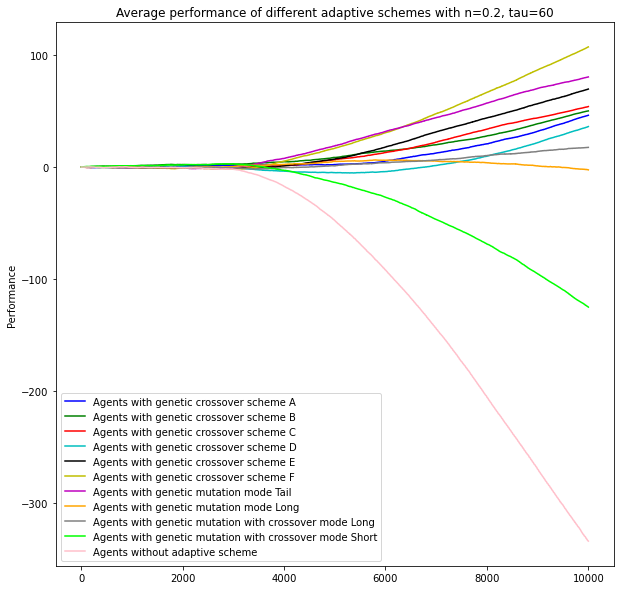

n=0.3, tau=10, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.3
Simulation Time: 1.411729 mins
n=0.3, tau=10, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.3
Simulation Time: 1.402824 mins
n=0.3, tau=10, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.3
Simulation Time: 1.404821 mins
n=0.3, tau=10, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.3
Simulation Time: 1.402879 mins
n=0.3, tau=10, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.3
Simulation Time: 1.406156 mins
n=0.3, tau=10, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.3
Simulation Time: 1.419027 mins
n=0.3, tau=10, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.3
Simulation Time: 1.402861 mins
n=0.3, tau=10, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.3
Simulation Time: 1.408268 mins
n=0.3, tau=10, Sample 9
Simulating competition w

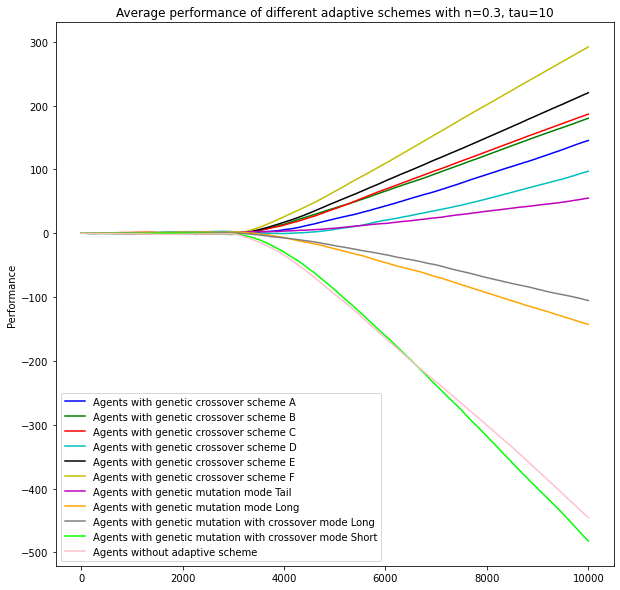

n=0.3, tau=20, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.3
Simulation Time: 1.338718 mins
n=0.3, tau=20, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.3
Simulation Time: 1.337364 mins
n=0.3, tau=20, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.3
Simulation Time: 1.347800 mins
n=0.3, tau=20, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.3
Simulation Time: 1.339659 mins
n=0.3, tau=20, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.3
Simulation Time: 1.340567 mins
n=0.3, tau=20, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.3
Simulation Time: 1.340236 mins
n=0.3, tau=20, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.3
Simulation Time: 1.343972 mins
n=0.3, tau=20, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.3
Simulation Time: 1.340057 mins
n=0.3, tau=20, Sample 9
Simulating competition w

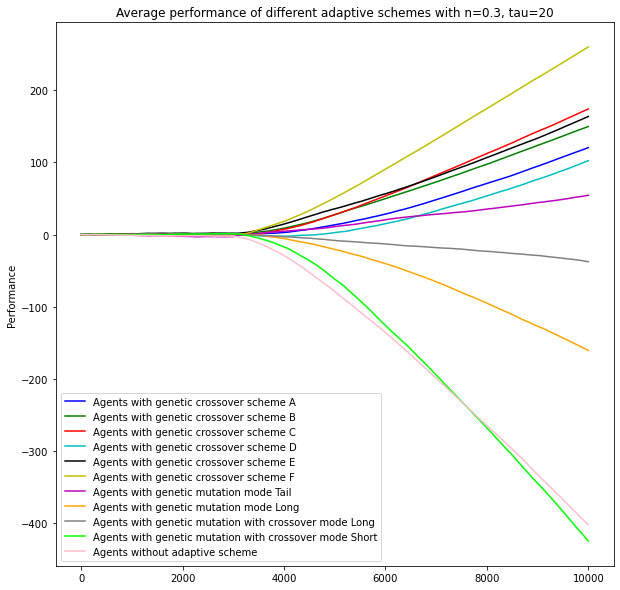

n=0.3, tau=30, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.3
Simulation Time: 1.314244 mins
n=0.3, tau=30, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.3
Simulation Time: 1.328113 mins
n=0.3, tau=30, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.3
Simulation Time: 1.315486 mins
n=0.3, tau=30, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.3
Simulation Time: 1.317146 mins
n=0.3, tau=30, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.3
Simulation Time: 1.318911 mins
n=0.3, tau=30, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.3
Simulation Time: 1.315985 mins
n=0.3, tau=30, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.3
Simulation Time: 1.316175 mins
n=0.3, tau=30, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.3
Simulation Time: 1.326909 mins
n=0.3, tau=30, Sample 9
Simulating competition w

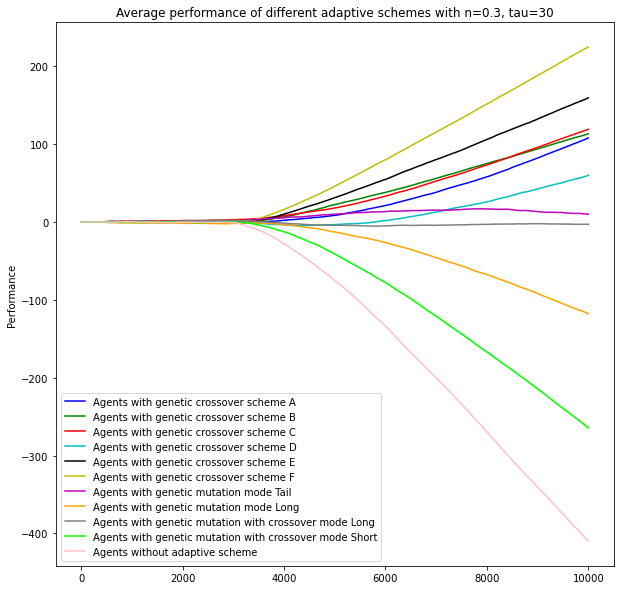

n=0.3, tau=40, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.3
Simulation Time: 1.305214 mins
n=0.3, tau=40, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.3
Simulation Time: 1.306408 mins
n=0.3, tau=40, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.3
Simulation Time: 1.304614 mins
n=0.3, tau=40, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.3
Simulation Time: 1.306724 mins
n=0.3, tau=40, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.3
Simulation Time: 1.317375 mins
n=0.3, tau=40, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.3
Simulation Time: 1.305287 mins
n=0.3, tau=40, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.3
Simulation Time: 1.315566 mins
n=0.3, tau=40, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.3
Simulation Time: 1.307229 mins
n=0.3, tau=40, Sample 9
Simulating competition w

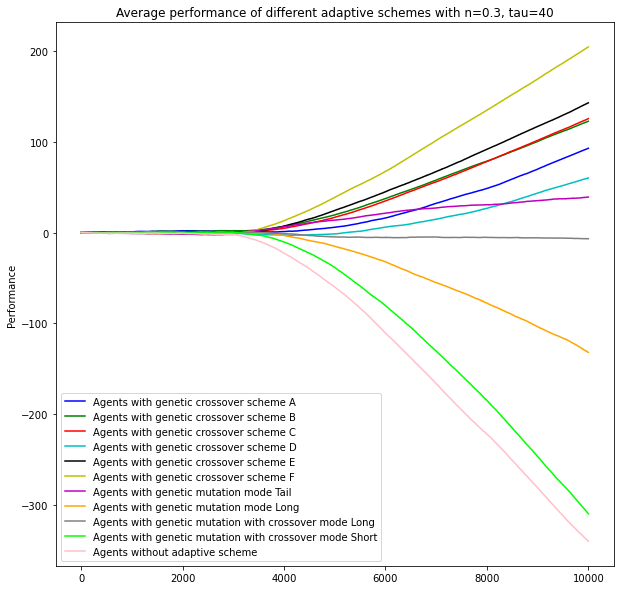

n=0.3, tau=50, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.3
Simulation Time: 1.297981 mins
n=0.3, tau=50, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.3
Simulation Time: 1.298262 mins
n=0.3, tau=50, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.3
Simulation Time: 1.308935 mins
n=0.3, tau=50, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.3
Simulation Time: 1.298377 mins
n=0.3, tau=50, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.3
Simulation Time: 1.301022 mins
n=0.3, tau=50, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.3
Simulation Time: 1.302259 mins
n=0.3, tau=50, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.3
Simulation Time: 1.298444 mins
n=0.3, tau=50, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.3
Simulation Time: 1.301069 mins
n=0.3, tau=50, Sample 9
Simulating competition w

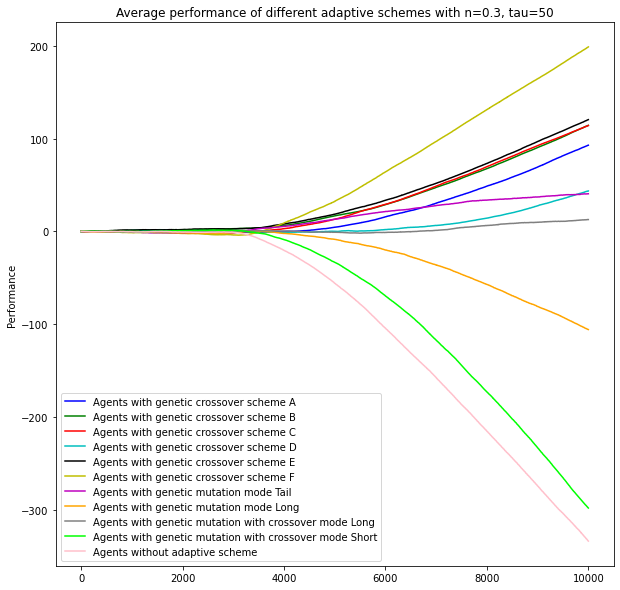

n=0.3, tau=60, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.3
Simulation Time: 1.299747 mins
n=0.3, tau=60, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.3
Simulation Time: 1.294719 mins
n=0.3, tau=60, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.3
Simulation Time: 1.292937 mins
n=0.3, tau=60, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.3
Simulation Time: 1.296332 mins
n=0.3, tau=60, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.3
Simulation Time: 1.293979 mins
n=0.3, tau=60, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.3
Simulation Time: 1.289070 mins
n=0.3, tau=60, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.3
Simulation Time: 1.294063 mins
n=0.3, tau=60, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.3
Simulation Time: 1.300222 mins
n=0.3, tau=60, Sample 9
Simulating competition w

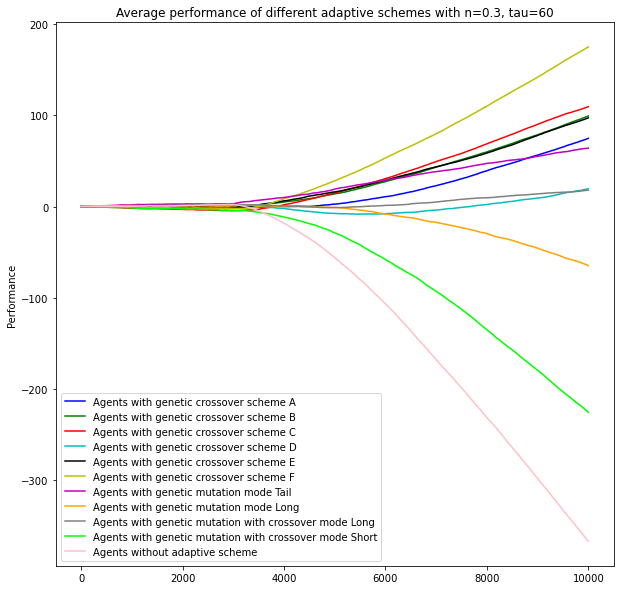

n=0.4, tau=10, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.4
Simulation Time: 1.453777 mins
n=0.4, tau=10, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.4
Simulation Time: 1.448393 mins
n=0.4, tau=10, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.4
Simulation Time: 1.453300 mins
n=0.4, tau=10, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.4
Simulation Time: 1.453074 mins
n=0.4, tau=10, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.4
Simulation Time: 1.458449 mins
n=0.4, tau=10, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.4
Simulation Time: 1.462128 mins
n=0.4, tau=10, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.4
Simulation Time: 1.452982 mins
n=0.4, tau=10, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.4
Simulation Time: 1.448796 mins
n=0.4, tau=10, Sample 9
Simulating competition w

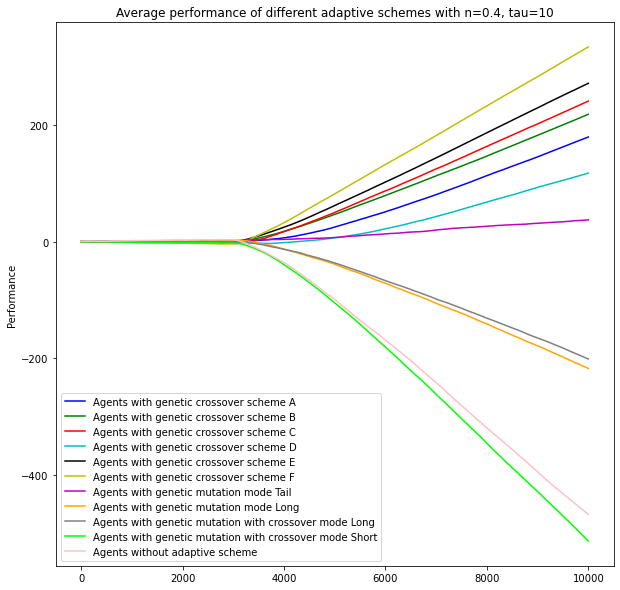

n=0.4, tau=20, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.4
Simulation Time: 1.361851 mins
n=0.4, tau=20, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.4
Simulation Time: 1.362181 mins
n=0.4, tau=20, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.4
Simulation Time: 1.371113 mins
n=0.4, tau=20, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.4
Simulation Time: 1.362624 mins
n=0.4, tau=20, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.4
Simulation Time: 1.360718 mins
n=0.4, tau=20, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.4
Simulation Time: 1.363682 mins
n=0.4, tau=20, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.4
Simulation Time: 1.364271 mins
n=0.4, tau=20, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.4
Simulation Time: 1.363947 mins
n=0.4, tau=20, Sample 9
Simulating competition w

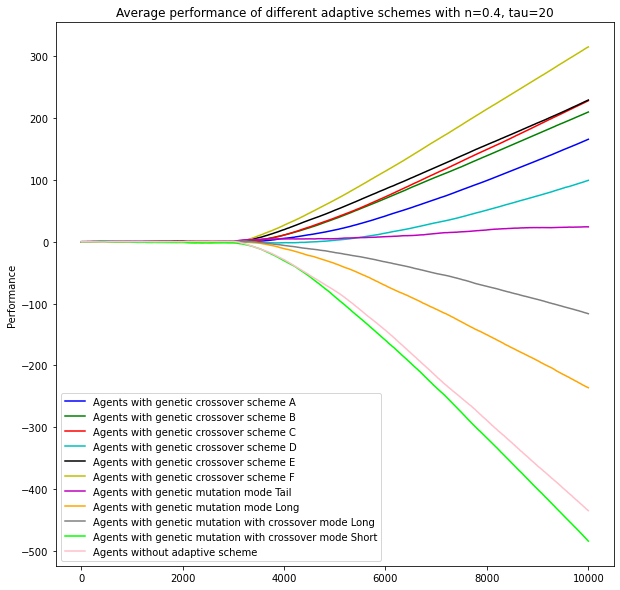

n=0.4, tau=30, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.4
Simulation Time: 1.335328 mins
n=0.4, tau=30, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.4
Simulation Time: 1.333760 mins
n=0.4, tau=30, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.4
Simulation Time: 1.334475 mins
n=0.4, tau=30, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.4
Simulation Time: 1.329436 mins
n=0.4, tau=30, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.4
Simulation Time: 1.330543 mins
n=0.4, tau=30, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.4
Simulation Time: 1.335848 mins
n=0.4, tau=30, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.4
Simulation Time: 1.345567 mins
n=0.4, tau=30, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.4
Simulation Time: 1.329928 mins
n=0.4, tau=30, Sample 9
Simulating competition w

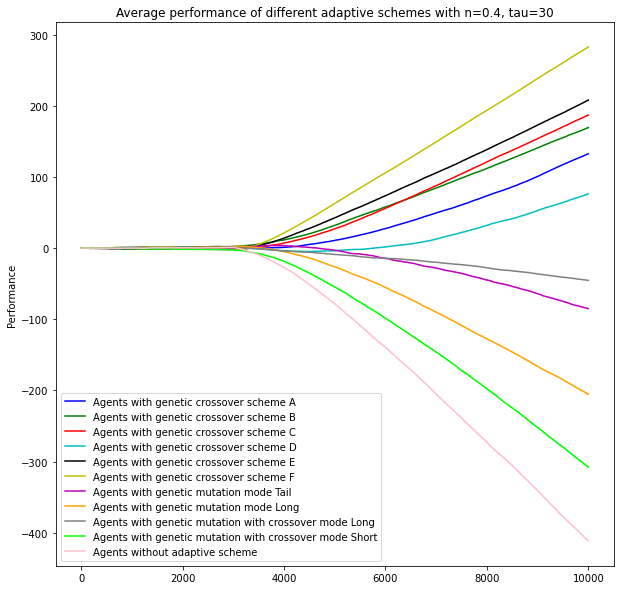

n=0.4, tau=40, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.4
Simulation Time: 1.317790 mins
n=0.4, tau=40, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.4
Simulation Time: 1.320320 mins
n=0.4, tau=40, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.4
Simulation Time: 1.317155 mins
n=0.4, tau=40, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.4
Simulation Time: 1.314159 mins
n=0.4, tau=40, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.4
Simulation Time: 1.328823 mins
n=0.4, tau=40, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.4
Simulation Time: 1.318183 mins
n=0.4, tau=40, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.4
Simulation Time: 1.316835 mins
n=0.4, tau=40, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.4
Simulation Time: 1.317198 mins
n=0.4, tau=40, Sample 9
Simulating competition w

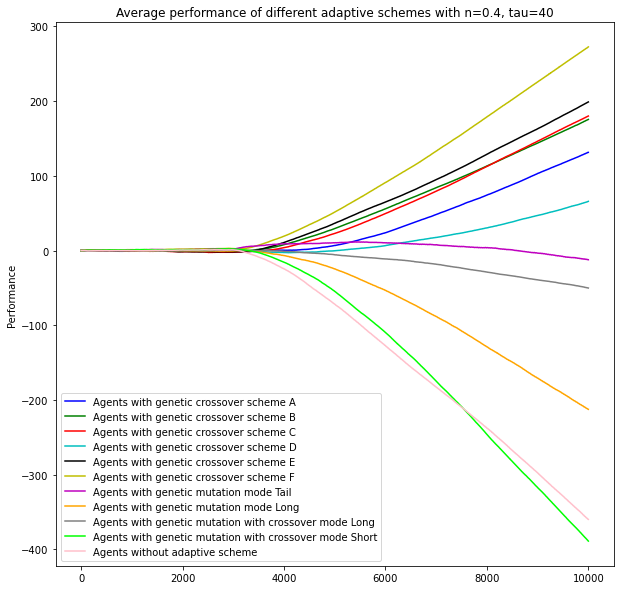

n=0.4, tau=50, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.4
Simulation Time: 1.308803 mins
n=0.4, tau=50, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.4
Simulation Time: 1.314918 mins
n=0.4, tau=50, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.4
Simulation Time: 1.308783 mins
n=0.4, tau=50, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.4
Simulation Time: 1.307436 mins
n=0.4, tau=50, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.4
Simulation Time: 1.306657 mins
n=0.4, tau=50, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.4
Simulation Time: 1.311672 mins
n=0.4, tau=50, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.4
Simulation Time: 1.307697 mins
n=0.4, tau=50, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.4
Simulation Time: 1.306194 mins
n=0.4, tau=50, Sample 9
Simulating competition w

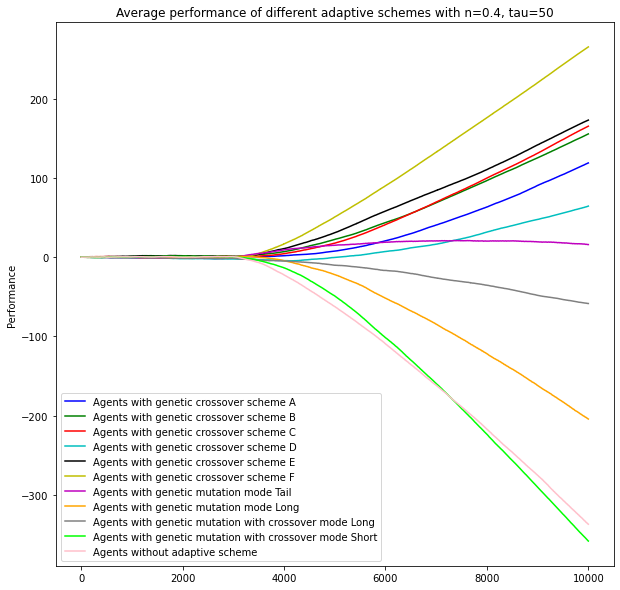

n=0.4, tau=60, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.4
Simulation Time: 1.302677 mins
n=0.4, tau=60, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.4
Simulation Time: 1.303659 mins
n=0.4, tau=60, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.4
Simulation Time: 1.303946 mins
n=0.4, tau=60, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.4
Simulation Time: 1.301824 mins
n=0.4, tau=60, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.4
Simulation Time: 1.299181 mins
n=0.4, tau=60, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.4
Simulation Time: 1.300264 mins
n=0.4, tau=60, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.4
Simulation Time: 1.301257 mins
n=0.4, tau=60, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.4
Simulation Time: 1.310207 mins
n=0.4, tau=60, Sample 9
Simulating competition w

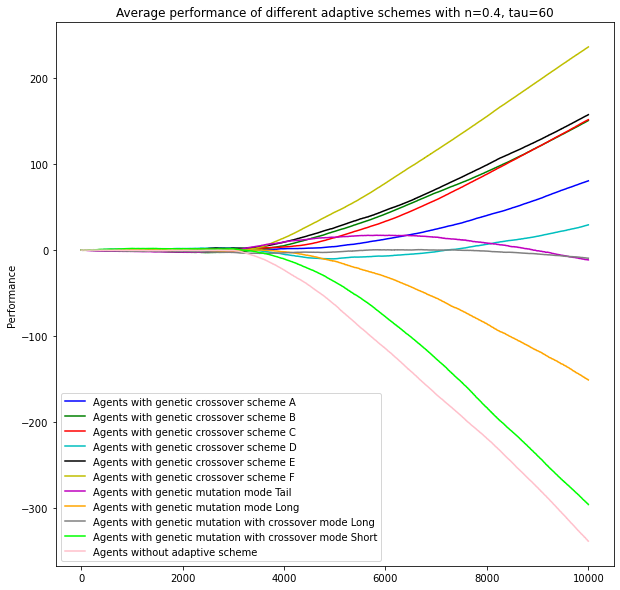

n=0.5, tau=10, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.5
Simulation Time: 1.500847 mins
n=0.5, tau=10, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.5
Simulation Time: 1.500895 mins
n=0.5, tau=10, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.5
Simulation Time: 1.495427 mins
n=0.5, tau=10, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.5
Simulation Time: 1.504169 mins
n=0.5, tau=10, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.5
Simulation Time: 1.508266 mins
n=0.5, tau=10, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.5
Simulation Time: 1.497716 mins
n=0.5, tau=10, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.5
Simulation Time: 1.504239 mins
n=0.5, tau=10, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.5
Simulation Time: 1.496797 mins
n=0.5, tau=10, Sample 9
Simulating competition w

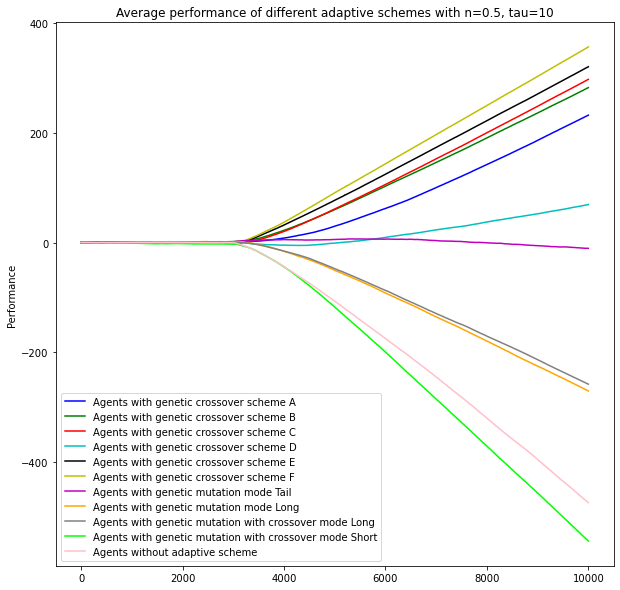

n=0.5, tau=20, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.5
Simulation Time: 1.391504 mins
n=0.5, tau=20, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.5
Simulation Time: 1.391488 mins
n=0.5, tau=20, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.5
Simulation Time: 1.386813 mins
n=0.5, tau=20, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.5
Simulation Time: 1.386249 mins
n=0.5, tau=20, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.5
Simulation Time: 1.388984 mins
n=0.5, tau=20, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.5
Simulation Time: 1.386809 mins
n=0.5, tau=20, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.5
Simulation Time: 1.387471 mins
n=0.5, tau=20, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.5
Simulation Time: 1.386919 mins
n=0.5, tau=20, Sample 9
Simulating competition w

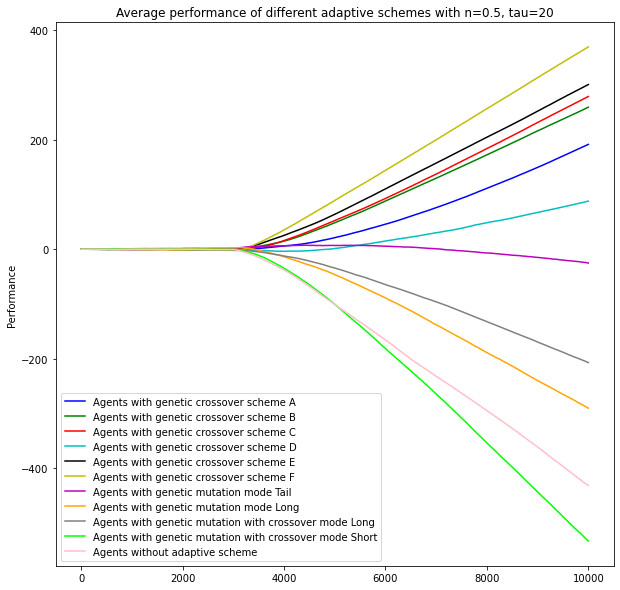

n=0.5, tau=30, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.5
Simulation Time: 1.348104 mins
n=0.5, tau=30, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.5
Simulation Time: 1.348971 mins
n=0.5, tau=30, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.5
Simulation Time: 1.345984 mins
n=0.5, tau=30, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.5
Simulation Time: 1.344100 mins
n=0.5, tau=30, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.5
Simulation Time: 1.349808 mins
n=0.5, tau=30, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.5
Simulation Time: 1.356974 mins
n=0.5, tau=30, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.5
Simulation Time: 1.345918 mins
n=0.5, tau=30, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.5
Simulation Time: 1.349078 mins
n=0.5, tau=30, Sample 9
Simulating competition w

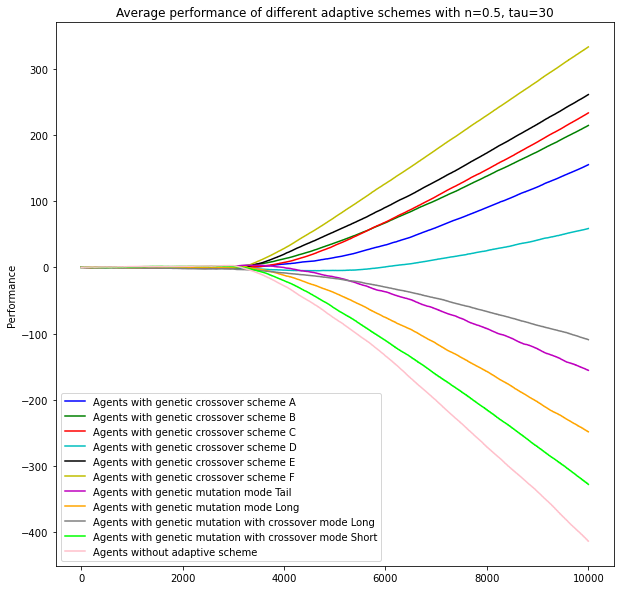

n=0.5, tau=40, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.5
Simulation Time: 1.326289 mins
n=0.5, tau=40, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.5
Simulation Time: 1.327679 mins
n=0.5, tau=40, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.5
Simulation Time: 1.330516 mins
n=0.5, tau=40, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.5
Simulation Time: 1.336313 mins
n=0.5, tau=40, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.5
Simulation Time: 1.328378 mins
n=0.5, tau=40, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.5
Simulation Time: 1.326250 mins
n=0.5, tau=40, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.5
Simulation Time: 1.327013 mins
n=0.5, tau=40, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.5
Simulation Time: 1.327712 mins
n=0.5, tau=40, Sample 9
Simulating competition w

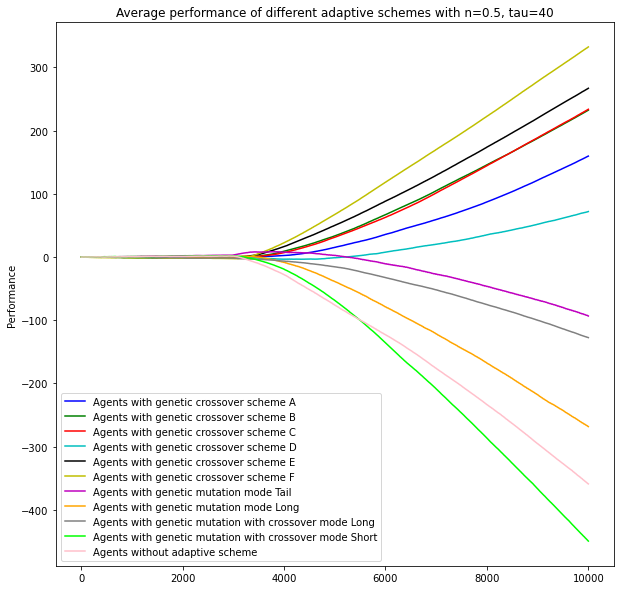

n=0.5, tau=50, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.5
Simulation Time: 1.322491 mins
n=0.5, tau=50, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.5
Simulation Time: 1.315410 mins
n=0.5, tau=50, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.5
Simulation Time: 1.317139 mins
n=0.5, tau=50, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.5
Simulation Time: 1.313298 mins
n=0.5, tau=50, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.5
Simulation Time: 1.315643 mins
n=0.5, tau=50, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.5
Simulation Time: 1.314542 mins
n=0.5, tau=50, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.5
Simulation Time: 1.315705 mins
n=0.5, tau=50, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.5
Simulation Time: 1.316980 mins
n=0.5, tau=50, Sample 9
Simulating competition w

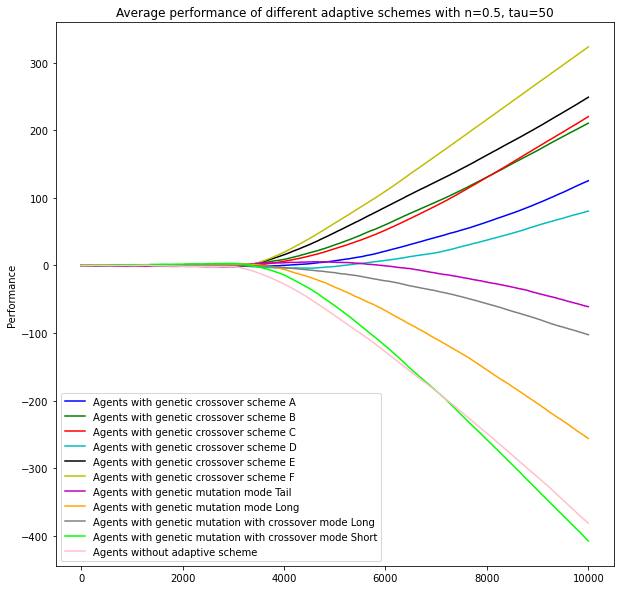

n=0.5, tau=60, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.5
Simulation Time: 1.309050 mins
n=0.5, tau=60, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.5
Simulation Time: 1.308252 mins
n=0.5, tau=60, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.5
Simulation Time: 1.307338 mins
n=0.5, tau=60, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.5
Simulation Time: 1.303937 mins
n=0.5, tau=60, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.5
Simulation Time: 1.307209 mins
n=0.5, tau=60, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.5
Simulation Time: 1.318956 mins
n=0.5, tau=60, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.5
Simulation Time: 1.304733 mins
n=0.5, tau=60, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.5
Simulation Time: 1.310304 mins
n=0.5, tau=60, Sample 9
Simulating competition w

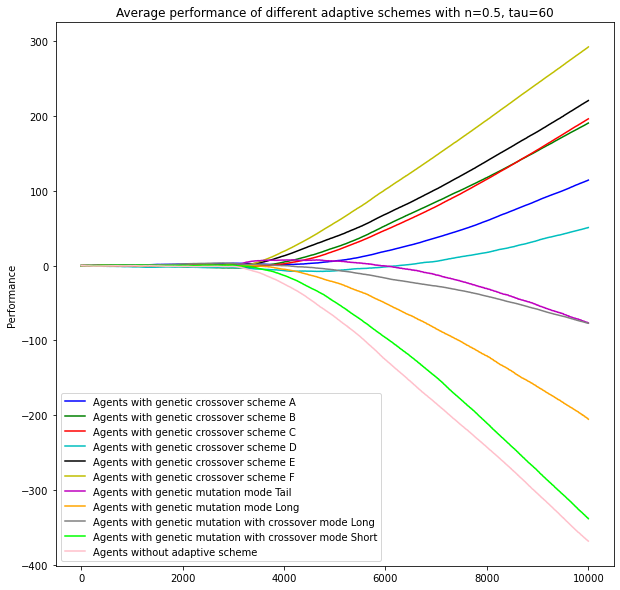

n=0.6, tau=10, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.6
Simulation Time: 1.542713 mins
n=0.6, tau=10, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.6
Simulation Time: 1.541850 mins
n=0.6, tau=10, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.6
Simulation Time: 1.550320 mins
n=0.6, tau=10, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.6
Simulation Time: 1.537133 mins
n=0.6, tau=10, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.6
Simulation Time: 1.541146 mins
n=0.6, tau=10, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.6
Simulation Time: 1.536395 mins
n=0.6, tau=10, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.6
Simulation Time: 1.539028 mins
n=0.6, tau=10, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=10,n=0.6
Simulation Time: 1.540121 mins
n=0.6, tau=10, Sample 9
Simulating competition w

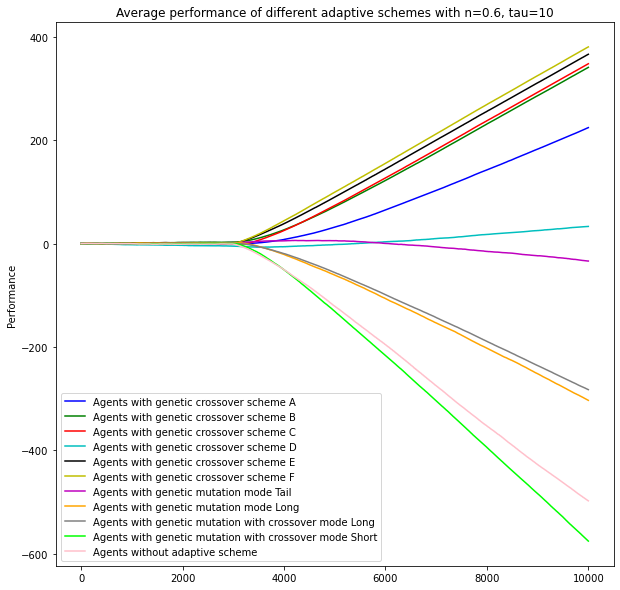

n=0.6, tau=20, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.6
Simulation Time: 1.411983 mins
n=0.6, tau=20, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.6
Simulation Time: 1.407434 mins
n=0.6, tau=20, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.6
Simulation Time: 1.413019 mins
n=0.6, tau=20, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.6
Simulation Time: 1.409939 mins
n=0.6, tau=20, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.6
Simulation Time: 1.408411 mins
n=0.6, tau=20, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.6
Simulation Time: 1.408998 mins
n=0.6, tau=20, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.6
Simulation Time: 1.423271 mins
n=0.6, tau=20, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=20,n=0.6
Simulation Time: 1.410595 mins
n=0.6, tau=20, Sample 9
Simulating competition w

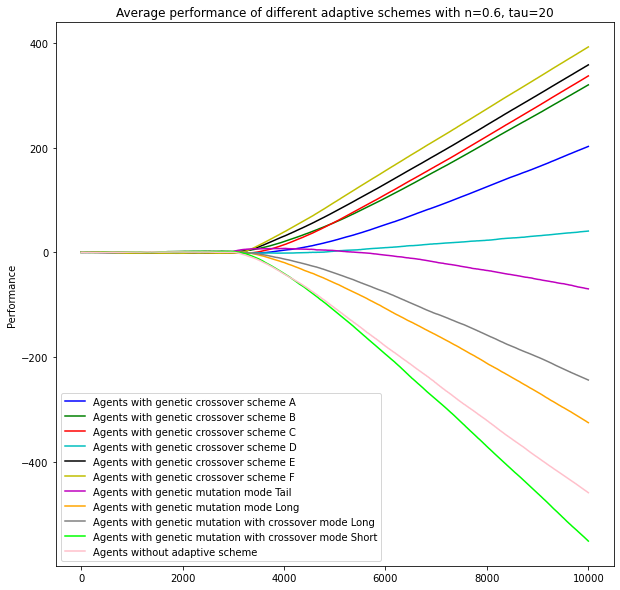

n=0.6, tau=30, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.6
Simulation Time: 1.368290 mins
n=0.6, tau=30, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.6
Simulation Time: 1.361815 mins
n=0.6, tau=30, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.6
Simulation Time: 1.365346 mins
n=0.6, tau=30, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.6
Simulation Time: 1.372302 mins
n=0.6, tau=30, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.6
Simulation Time: 1.365474 mins
n=0.6, tau=30, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.6
Simulation Time: 1.362942 mins
n=0.6, tau=30, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.6
Simulation Time: 1.371150 mins
n=0.6, tau=30, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=30,n=0.6
Simulation Time: 1.363342 mins
n=0.6, tau=30, Sample 9
Simulating competition w

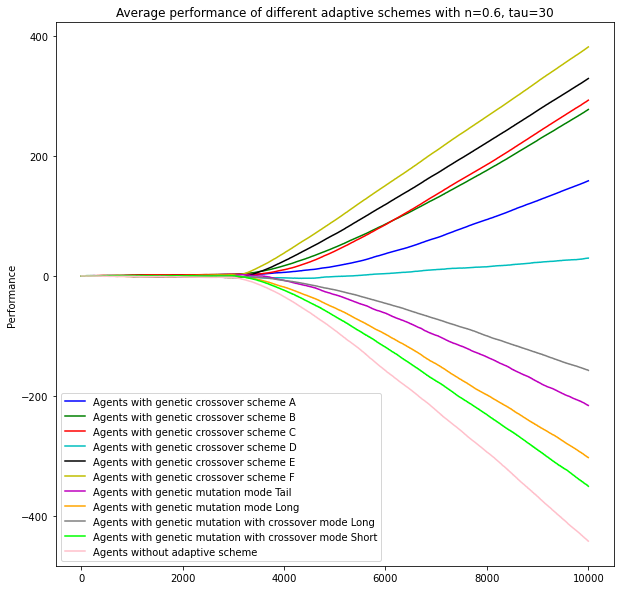

n=0.6, tau=40, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.6
Simulation Time: 1.355126 mins
n=0.6, tau=40, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.6
Simulation Time: 1.341895 mins
n=0.6, tau=40, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.6
Simulation Time: 1.344022 mins
n=0.6, tau=40, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.6
Simulation Time: 1.346696 mins
n=0.6, tau=40, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.6
Simulation Time: 1.346114 mins
n=0.6, tau=40, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.6
Simulation Time: 1.343319 mins
n=0.6, tau=40, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.6
Simulation Time: 1.345422 mins
n=0.6, tau=40, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=40,n=0.6
Simulation Time: 1.342810 mins
n=0.6, tau=40, Sample 9
Simulating competition w

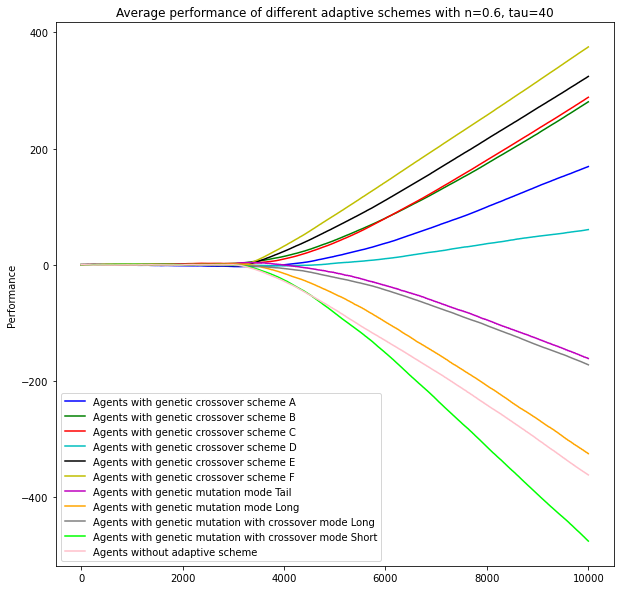

n=0.6, tau=50, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.6
Simulation Time: 1.327394 mins
n=0.6, tau=50, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.6
Simulation Time: 1.328879 mins
n=0.6, tau=50, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.6
Simulation Time: 1.335397 mins
n=0.6, tau=50, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.6
Simulation Time: 1.328497 mins
n=0.6, tau=50, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.6
Simulation Time: 1.427330 mins
n=0.6, tau=50, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.6
Simulation Time: 1.333961 mins
n=0.6, tau=50, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.6
Simulation Time: 1.328189 mins
n=0.6, tau=50, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=50,n=0.6
Simulation Time: 1.329756 mins
n=0.6, tau=50, Sample 9
Simulating competition w

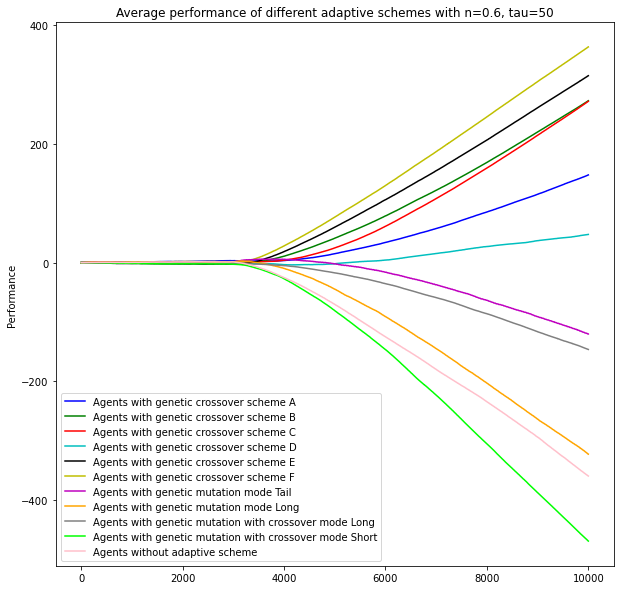

n=0.6, tau=60, Sample 1
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.6
Simulation Time: 1.319474 mins
n=0.6, tau=60, Sample 2
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.6
Simulation Time: 1.321318 mins
n=0.6, tau=60, Sample 3
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.6
Simulation Time: 1.320917 mins
n=0.6, tau=60, Sample 4
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.6
Simulation Time: 1.327661 mins
n=0.6, tau=60, Sample 5
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.6
Simulation Time: 1.315880 mins
n=0.6, tau=60, Sample 6
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.6
Simulation Time: 1.316373 mins
n=0.6, tau=60, Sample 7
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.6
Simulation Time: 1.321067 mins
n=0.6, tau=60, Sample 8
Simulating competition with m=4,N=539,S=10,T=10000,tau=60,n=0.6
Simulation Time: 1.318889 mins
n=0.6, tau=60, Sample 9
Simulating competition w

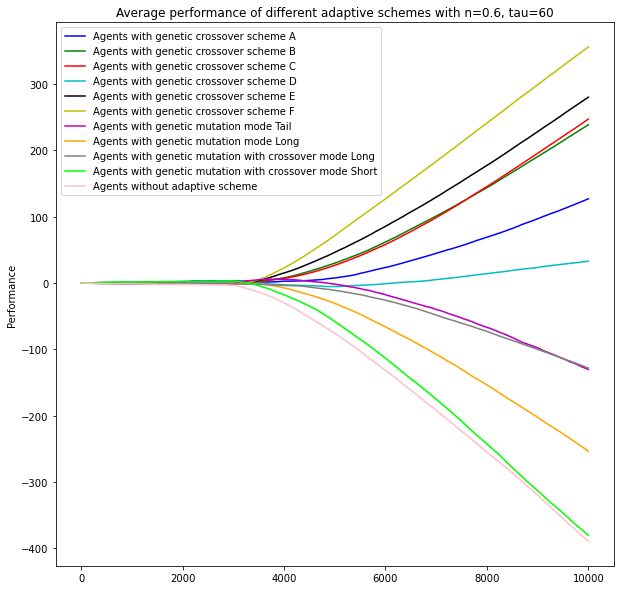

In [8]:
n_array = [0.1,0.2,0.3,0.4,0.5,0.6]
tau_array = [10,20,30,40,50,60]
samples = 10
for nnn in n_array:
    for ttt in tau_array:
        performance_array = []
        for s in range(samples):
            print(f'n={nnn}, tau={ttt}, Sample {s+1}')
            st = time.time()
            b, r, g = mg_competition(n=nnn, tau=ttt)
            print(f'Simulation Time: {(time.time()-st)/60:2f} mins')
            r_norm = r-r.mean(axis=0)
            performance_average = []
            for i in range(11):
                gr = r_norm[g[i],:]
                performance_average.append(gr.mean(axis=0))
            performance_array.append(performance_average)
            
        color = ['b','g','r','c','k','y','m','orange','grey','lime','pink']
        mode_m = ['Tail','Long']
        mode_cm = ['Long','Short']
        
        fig = plt.figure(figsize=(10,10))
        for i in range(11):
            average_performance = np.zeros(len(performance_array[0][0]))
            for j in range(samples):
                average_performance += performance_array[j][i]
            average_performance = average_performance/samples
            if i<6:
                plt.plot(average_performance, c=color[i], label=f'Agents with genetic crossover scheme {schemes[i]}')
            elif i<8:
                plt.plot(average_performance, c=color[i], label=f'Agents with genetic mutation mode {mode_m[i-6]}')
            elif i<10:
                plt.plot(average_performance, c=color[i], label=f'Agents with genetic mutation with crossover mode {mode_cm[i-8]}')
            else:
                plt.plot(average_performance, c=color[i], label='Agents without adaptive scheme')
        plt.legend()
        plt.ylabel('Performance')
        plt.title(f'Average performance of different adaptive schemes with n={nnn}, tau={ttt}')
        plt.show()
